<a href="https://colab.research.google.com/github/MehrdadJalali-AI/BlackHole/blob/main/sparsification_analysis_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
from io import StringIO
import time
from requests.exceptions import HTTPError

sns.set(style="whitegrid", context="notebook", palette="deep")

method_colors = {'blackhole': '#2E2E2E'}
method_styles = {'blackhole': '-'}
method_markers = {'blackhole': 'o'}

output_dir = 'plots_bh'
os.makedirs(output_dir, exist_ok=True)

threshold_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
run_ids = range(10)
github_base_url = "https://raw.githubusercontent.com/MehrdadJalali-AI/BlackHole/main/sparsified_graphs"

def fetch_with_retry(url, max_retries=5, initial_delay=1):
    for attempt in range(max_retries):
        try:
            response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
            response.raise_for_status()
            return response
        except HTTPError as e:
            if response.status_code == 429:
                delay = initial_delay * (2 ** attempt)
                print(f"Rate limit hit for {url}. Retrying in {delay} seconds...")
                time.sleep(delay)
            else:
                raise
        except Exception as e:
            print(f"Failed to load {url}: {e}")
            break
    return None

data_frames = []
for thresh in threshold_values:
    thresh_str = f"{thresh:.2f}"
    for run in run_ids:
        directory = f"threshold_{thresh_str}/method_blackhole/run_{run}"
        filename = f"remaining_node_features_t{thresh_str}_r{run}.csv"
        url = f"{github_base_url}/{directory}/{filename}"
        response = fetch_with_retry(url)
        if response:
            try:
                df = pd.read_csv(StringIO(response.text))
                df['Threshold'] = thresh
                df['Run'] = run
                df['Method'] = 'blackhole'
                data_frames.append(df)
            except Exception as e:
                print(f"Failed to parse {filename}: {e}")
        time.sleep(0.5)  # Small delay between requests

if not data_frames:
    raise ValueError("No data loaded. Please check URLs or availability.")
df = pd.concat(data_frames, ignore_index=True)

agg_data = df.groupby(['Threshold', 'Method']).agg(
    Gravity_mean=('Gravity', 'mean'),
    Gravity_sem=('Gravity', lambda x: x.std(ddof=1) / np.sqrt(len(x))),
    Degree_Centrality_mean=('Degree_Centrality', 'mean'),
    Degree_Centrality_sem=('Degree_Centrality', lambda x: x.std(ddof=1) / np.sqrt(len(x))),
    Betweenness_Centrality_mean=('Betweenness_Centrality', 'mean'),
    Betweenness_Centrality_sem=('Betweenness_Centrality', lambda x: x.std(ddof=1) / np.sqrt(len(x))),
    Edge_Weight_Sum_mean=('Edge_Weight_Sum', 'mean'),
    Edge_Weight_Sum_sem=('Edge_Weight_Sum', lambda x: x.std(ddof=1) / np.sqrt(len(x))),
    Num_Nodes=('Community_ID', 'count')
).reset_index()

# Calculate Percentage Sparsification
base_nodes = agg_data[agg_data['Threshold'] == 0.0]['Num_Nodes'].iloc[0]
agg_data['Percentage_Sparsification'] = (1 - agg_data['Num_Nodes'] / base_nodes) * 100
agg_data['Percentage_Sparsification_sem'] = 0.0  # SEM not applicable for deterministic count

def normalize_metric(data, metric_mean, metric_sem, base_value):
    mean = data[metric_mean]
    sem = data[metric_sem]
    if metric_mean in ['Gravity_mean', 'Edge_Weight_Sum_mean']:
        normalized = mean / base_value if base_value > 0 else mean
    elif metric_mean == 'Betweenness_Centrality_mean':
        normalized = base_value / mean if mean > 0 else 1.0
    else:
        normalized = mean
    return normalized, sem / base_value if base_value > 0 else sem

base_data = agg_data[agg_data['Threshold'] == 0.0].iloc[0]
bh_index_data = agg_data.copy()
bh_index_data['BH_Advantage_Index'] = 0.0
bh_index_data['BH_Advantage_SEM'] = 0.0

weights = {'Gravity_mean': 0.3, 'Edge_Weight_Sum_mean': 0.3, 'Betweenness_Centrality_mean': 0.2, 'Degree_Centrality_mean': 0.2}
for idx, row in bh_index_data.iterrows():
    norm_gravity, sem_gravity = normalize_metric(row, 'Gravity_mean', 'Gravity_sem', base_data['Gravity_mean'])
    norm_edge_weight, sem_edge_weight = normalize_metric(row, 'Edge_Weight_Sum_mean', 'Edge_Weight_Sum_sem', base_data['Edge_Weight_Sum_mean'])
    norm_betweenness, sem_betweenness = normalize_metric(row, 'Betweenness_Centrality_mean', 'Betweenness_Centrality_sem', base_data['Betweenness_Centrality_mean'])
    norm_degree, sem_degree = normalize_metric(row, 'Degree_Centrality_mean', 'Degree_Centrality_sem', base_data['Degree_Centrality_mean'])

    bh_index = (weights['Gravity_mean'] * norm_gravity +
                weights['Edge_Weight_Sum_mean'] * norm_edge_weight +
                weights['Betweenness_Centrality_mean'] * norm_betweenness +
                weights['Degree_Centrality_mean'] * norm_degree)
    bh_sem = (weights['Gravity_mean'] * sem_gravity +
              weights['Edge_Weight_Sum_mean'] * sem_edge_weight +
              weights['Betweenness_Centrality_mean'] * sem_betweenness +
              weights['Degree_Centrality_mean'] * sem_degree)

    bh_index_data.at[idx, 'BH_Advantage_Index'] = bh_index
    bh_index_data.at[idx, 'BH_Advantage_SEM'] = bh_sem

def plot_metric(data, metric, sem_metric, title_prefix, baseline=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    method = 'blackhole'
    method_data = data[data['Method'] == method].sort_values('Threshold')

    ax.plot(method_data['Threshold'], method_data[metric],
            label=f'{method.title()}',
            color=method_colors[method],
            linestyle=method_styles[method],
            marker=method_markers[method],
            markersize=8)
    ax.fill_between(method_data['Threshold'],
                    method_data[metric] - method_data[sem_metric],
                    method_data[metric] + method_data[sem_metric],
                    color=method_colors[method],
                    alpha=0.2)

    if baseline is not None:
        ax.axhline(y=baseline, color='gray', linestyle='--', label='Original Graph', alpha=0.5)

    max_idx = method_data[metric].idxmax()
    max_value = method_data[metric].iloc[max_idx]
    max_thresh = method_data['Threshold'].iloc[max_idx]
    if metric != 'Percentage_Sparsification' and max_value > method_data[metric].iloc[0]:
        ax.plot(max_thresh, max_value, marker='o', color='red', markersize=8)

    metric_name = metric.replace("_mean", "").replace("_", " ").title()
    ax.set_title(f'{title_prefix} in BH', fontsize=14)
    ax.set_xlabel('Threshold (Pruning Rate)', fontsize=12)
    ax.set_ylabel(metric_name, fontsize=12, color='black')
    ax.set_xticks(threshold_values)
    if metric == 'Betweenness_Centrality_mean':
        ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

    if metric == 'BH_Advantage_Index':
        ax2 = ax.twinx()
        ax2.plot(method_data['Threshold'], method_data['Betweenness_Centrality_mean'],
                 color='purple', linestyle=':', label='Betweenness (Secondary)', alpha=0.7)
        ax2.set_ylabel('Betweenness Centrality', fontsize=12, color='black')
        ax2.tick_params(axis='y', labelcolor='purple')
        ax2.set_yscale('log')

    filename = f"{title_prefix.lower()}_{metric.replace('_', '-')}.png"
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.close()

network_metrics = [
    ('Gravity', 'Gravity'),
    ('Degree_Centrality', 'Degree Centrality'),
    ('Betweenness_Centrality', 'Betweenness Centrality'),
    ('Edge_Weight_Sum', 'Edge Weight Sum'),
    ('Percentage_Sparsification', 'Percentage Sparsification')
]

for metric_base, title_label in network_metrics:
    baseline = agg_data[agg_data['Threshold'] == 0.0][f'{metric_base}_mean'].iloc[0] if metric_base != 'Percentage_Sparsification' else 0.0
    plot_metric(agg_data, f'{metric_base}_mean' if metric_base != 'Percentage_Sparsification' else 'Percentage_Sparsification',
                f'{metric_base}_sem' if metric_base != 'Percentage_Sparsification' else 'Percentage_Sparsification_sem',
                title_label, baseline)

plot_metric(bh_index_data, 'BH_Advantage_Index', 'BH_Advantage_SEM', 'Black Hole Advantage', 1.0)

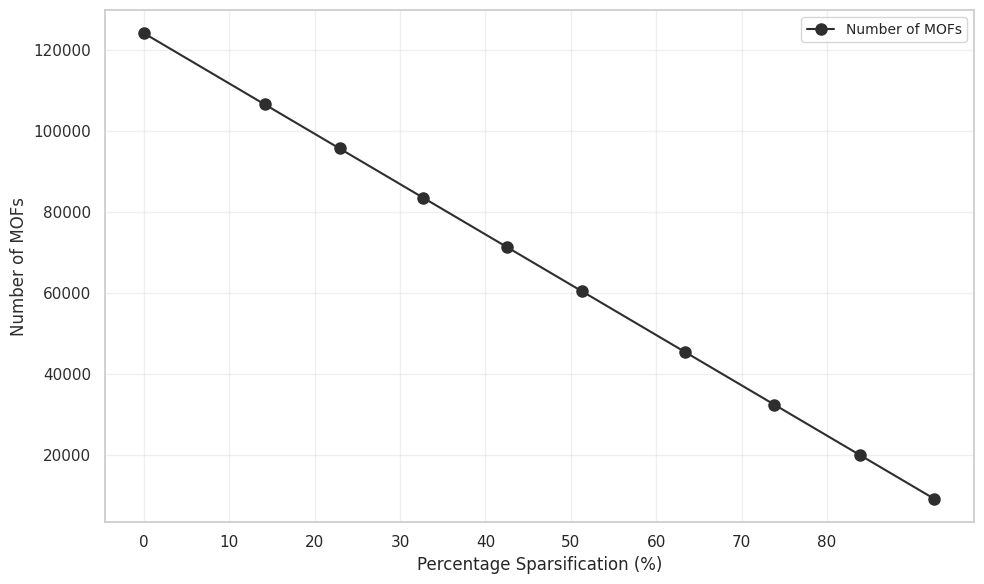

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
from io import StringIO
import time
from requests.exceptions import HTTPError

sns.set(style="whitegrid", context="notebook", palette="deep")

method_colors = {'blackhole': '#2E2E2E'}
method_styles = {'blackhole': '-'}
method_markers = {'blackhole': 'o'}

output_dir = 'plots_bh'
os.makedirs(output_dir, exist_ok=True)

threshold_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
run_ids = range(10)
github_base_url = "https://raw.githubusercontent.com/MehrdadJalali-AI/BlackHole/main/sparsified_graphs"

def fetch_with_retry(url, max_retries=5, initial_delay=1):
    for attempt in range(max_retries):
        try:
            response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
            response.raise_for_status()
            return response
        except HTTPError as e:
            if response.status_code == 429:
                delay = initial_delay * (2 ** attempt)
                print(f"Rate limit hit for {url}. Retrying in {delay} seconds...")
                time.sleep(delay)
            else:
                raise
        except Exception as e:
            print(f"Failed to load {url}: {e}")
            break
    return None

data_frames = []
for thresh in threshold_values:
    thresh_str = f"{thresh:.2f}"
    for run in run_ids:
        directory = f"threshold_{thresh_str}/method_blackhole/run_{run}"
        filename = f"remaining_node_features_t{thresh_str}_r{run}.csv"
        url = f"{github_base_url}/{directory}/{filename}"
        response = fetch_with_retry(url)
        if response:
            try:
                df = pd.read_csv(StringIO(response.text))
                df['Threshold'] = thresh
                df['Run'] = run
                df['Method'] = 'blackhole'
                data_frames.append(df)
            except Exception as e:
                print(f"Failed to parse {filename}: {e}")
        time.sleep(0.5)  # Small delay between requests

if not data_frames:
    raise ValueError("No data loaded. Please check URLs or availability.")
df = pd.concat(data_frames, ignore_index=True)

agg_data = df.groupby(['Threshold', 'Method']).agg(
    Num_Nodes=('Community_ID', 'count')
).reset_index()

# Calculate Percentage Sparsification
base_nodes = agg_data[agg_data['Threshold'] == 0.0]['Num_Nodes'].iloc[0]
agg_data['Percentage_Sparsification'] = (1 - agg_data['Num_Nodes'] / base_nodes) * 100

# Plot Number of MOFs vs Percentage Sparsification
fig, ax = plt.subplots(figsize=(10, 6))
method = 'blackhole'
method_data = agg_data[agg_data['Method'] == method].sort_values('Threshold')

ax.plot(method_data['Percentage_Sparsification'], method_data['Num_Nodes'],
        label='Number of MOFs',
        color=method_colors[method],
        linestyle=method_styles[method],
        marker=method_markers[method],
        markersize=8)
ax.set_xlabel('Percentage Sparsification (%)', fontsize=12)
ax.set_ylabel('Number of MOFs', fontsize=12, color=method_colors[method])
ax.tick_params(axis='y', labelcolor=method_colors[method])
ax.set_xticks(np.arange(0, 90, 10))  # Set x-axis ticks from 0 to 80 with 10% intervals
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig(f'{output_dir}/mofs_vs_sparsification.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

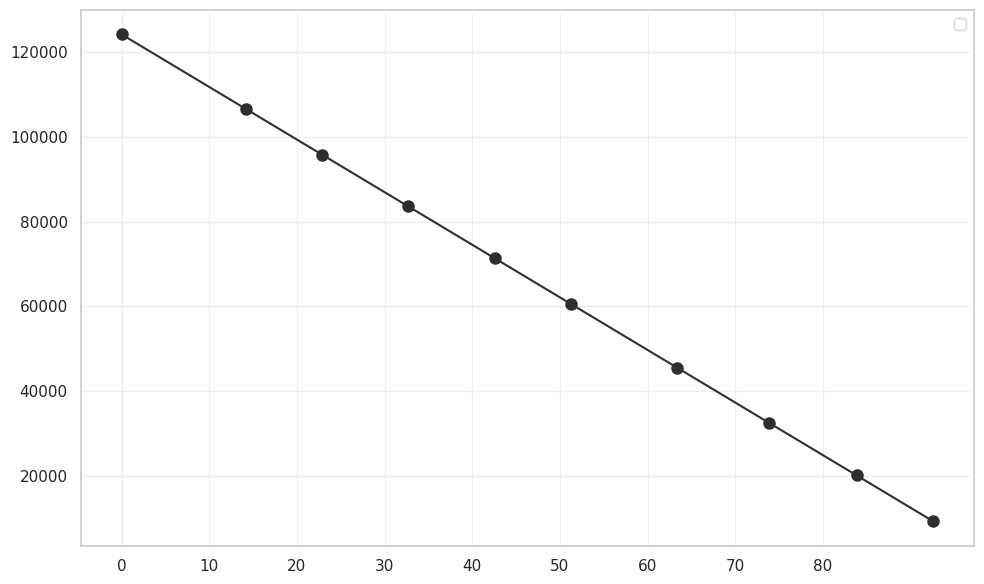

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
from io import StringIO
import time
from requests.exceptions import HTTPError

sns.set(style="whitegrid", context="notebook", palette="deep")

method_colors = {'blackhole': '#2E2E2E'}
method_styles = {'blackhole': '-'}
method_markers = {'blackhole': 'o'}

output_dir = 'plots_bh'
os.makedirs(output_dir, exist_ok=True)

threshold_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
run_ids = range(10)
github_base_url = "https://raw.githubusercontent.com/MehrdadJalali-AI/BlackHole/main/sparsified_graphs"

def fetch_with_retry(url, max_retries=5, initial_delay=1):
    for attempt in range(max_retries):
        try:
            response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
            response.raise_for_status()
            return response
        except HTTPError as e:
            if response.status_code == 429:
                delay = initial_delay * (2 ** attempt)
                print(f"Rate limit hit for {url}. Retrying in {delay} seconds...")
                time.sleep(delay)
            else:
                raise
        except Exception as e:
            print(f"Failed to load {url}: {e}")
            break
    return None

data_frames = []
for thresh in threshold_values:
    thresh_str = f"{thresh:.2f}"
    for run in run_ids:
        directory = f"threshold_{thresh_str}/method_blackhole/run_{run}"
        filename = f"remaining_node_features_t{thresh_str}_r{run}.csv"
        url = f"{github_base_url}/{directory}/{filename}"
        response = fetch_with_retry(url)
        if response:
            try:
                df = pd.read_csv(StringIO(response.text))
                df['Threshold'] = thresh
                df['Run'] = run
                df['Method'] = 'blackhole'
                data_frames.append(df)
            except Exception as e:
                print(f"Failed to parse {filename}: {e}")
        time.sleep(0.5)  # Small delay between requests

if not data_frames:
    raise ValueError("No data loaded. Please check URLs or availability.")
df = pd.concat(data_frames, ignore_index=True)

aggkong = df.groupby(['Threshold', 'Method']).agg(
    Num_Nodes=('Community_ID', 'count')
).reset_index()

# Calculate Percentage Sparsification
base_nodes = aggkong[aggkong['Threshold'] == 0.0]['Num_Nodes'].iloc[0]
aggkong['Percentage_Sparsification'] = (1 - aggkong['Num_Nodes'] / base_nodes) * 100

# Plot Number of MOFs vs Percentage Sparsification without labels
fig, ax = plt.subplots(figsize=(10, 6))
method = 'blackhole'
method_data = aggkong[aggkong['Method'] == method].sort_values('Threshold')

ax.plot(method_data['Percentage_Sparsification'], method_data['Num_Nodes'],
        color=method_colors[method],
        linestyle=method_styles[method],
        marker=method_markers[method],
        markersize=8)
ax.set_xticks(np.arange(0, 90, 10))  # Set x-axis ticks from 0 to 80 with 10% intervals
ax.grid(True, alpha=0.3)

# Remove all labels, title, and legend
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.legend([])  # Clear the legend

plt.tight_layout()
plt.savefig(f'{output_dir}/mofs_vs_sparsification_no_labels.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

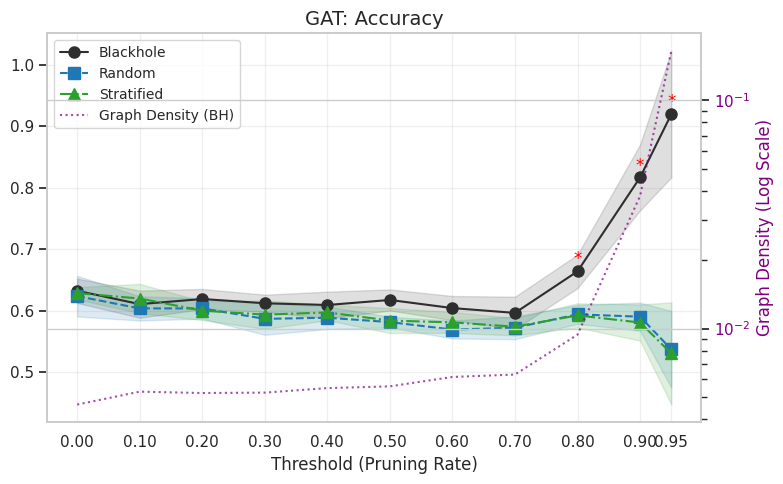

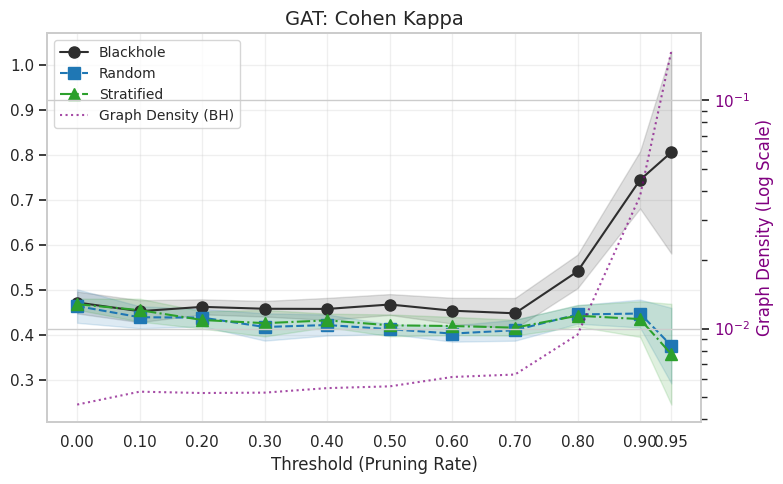

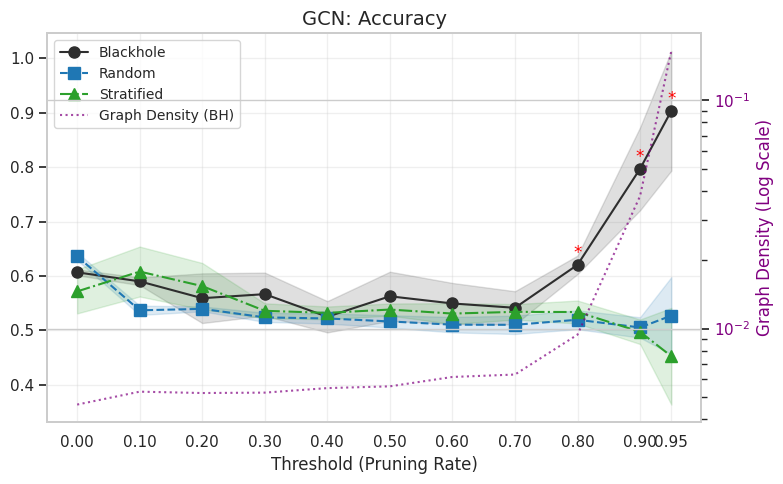

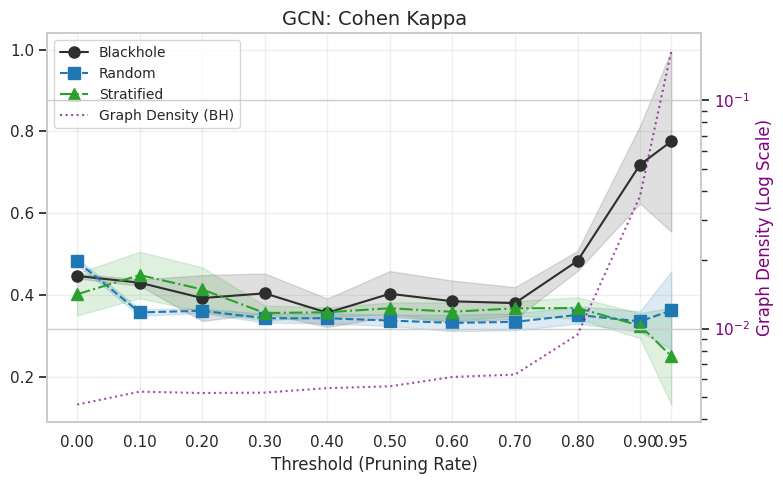

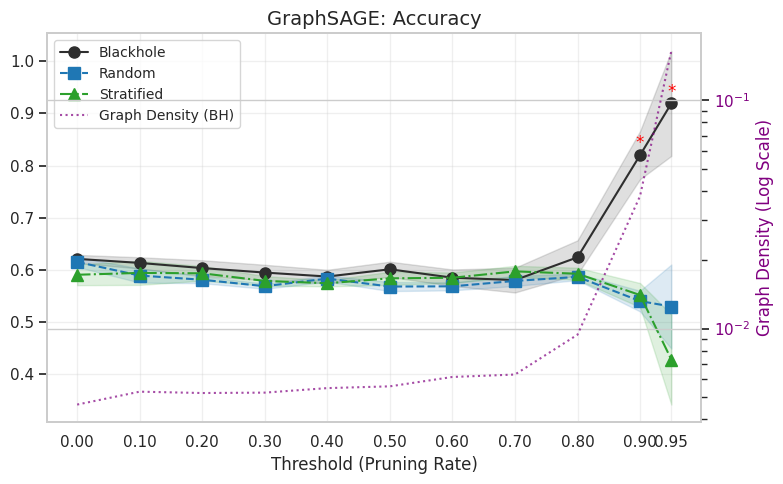

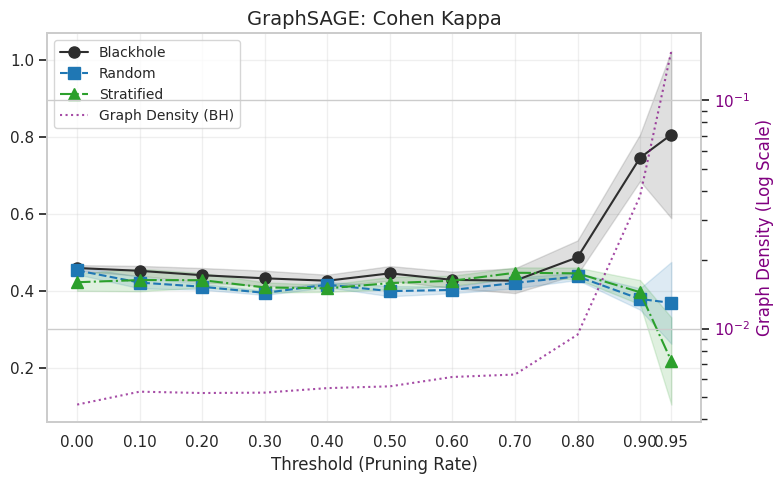

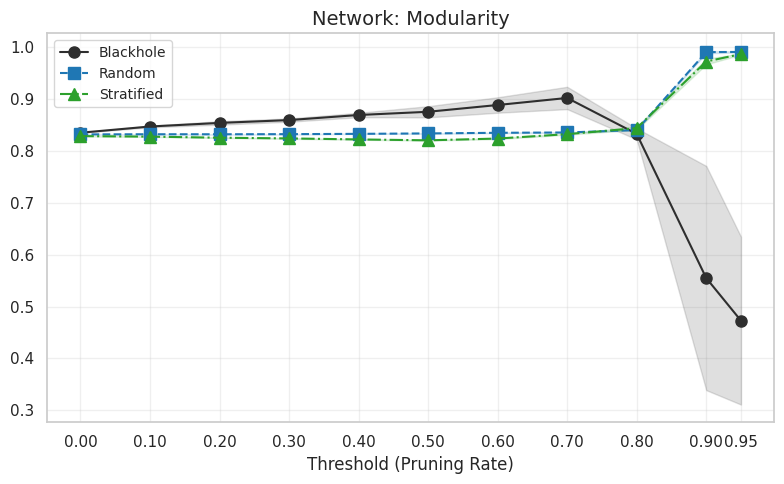

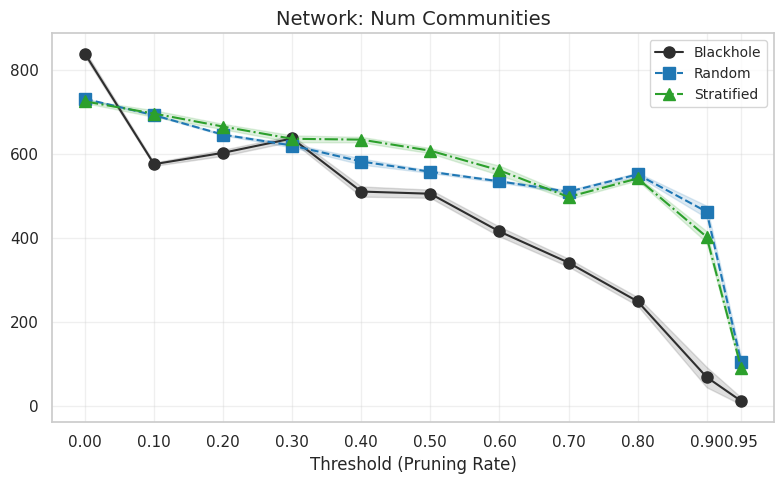

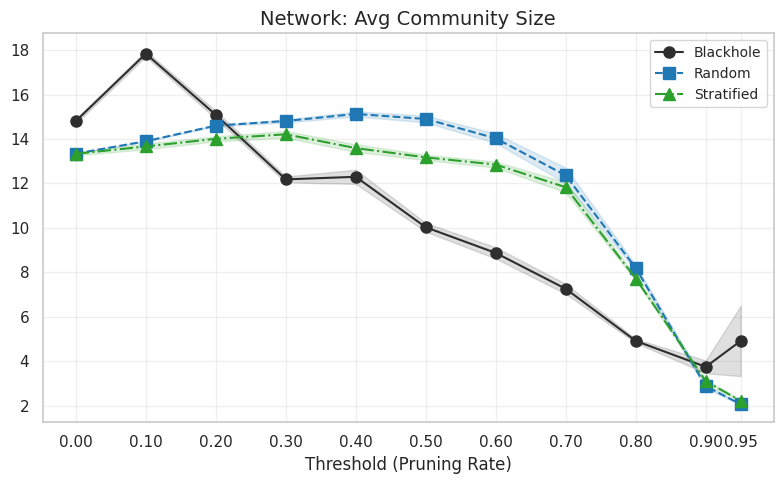

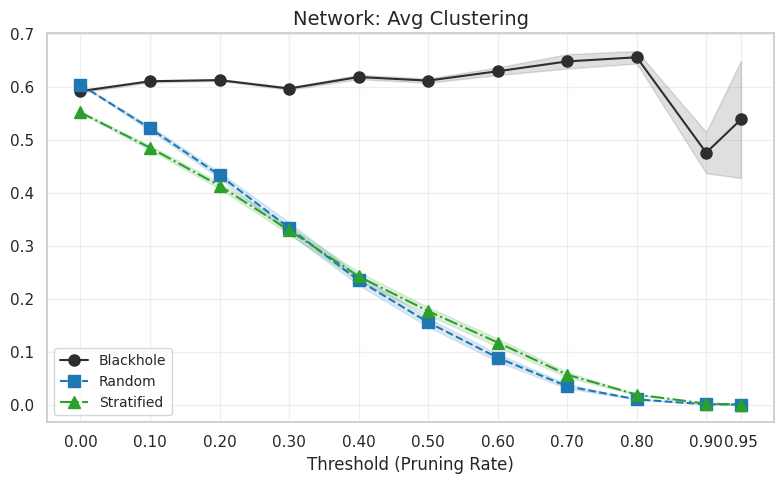

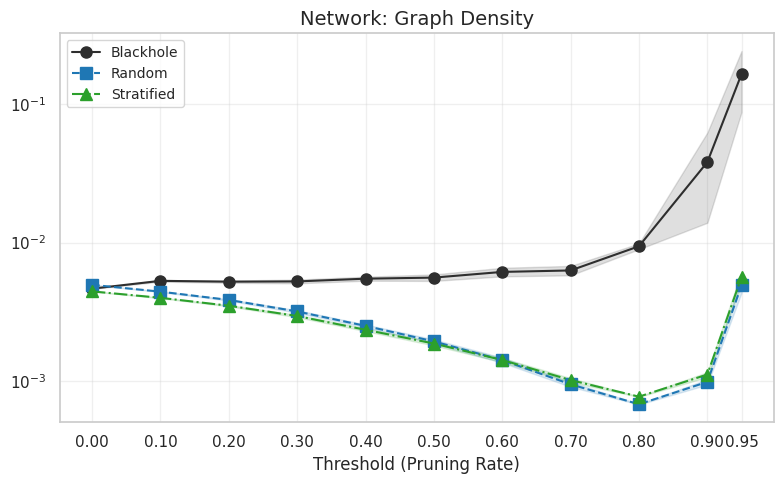

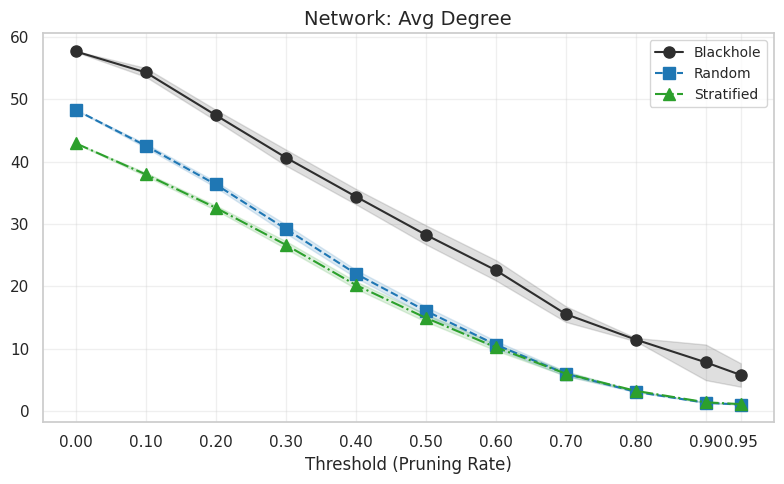

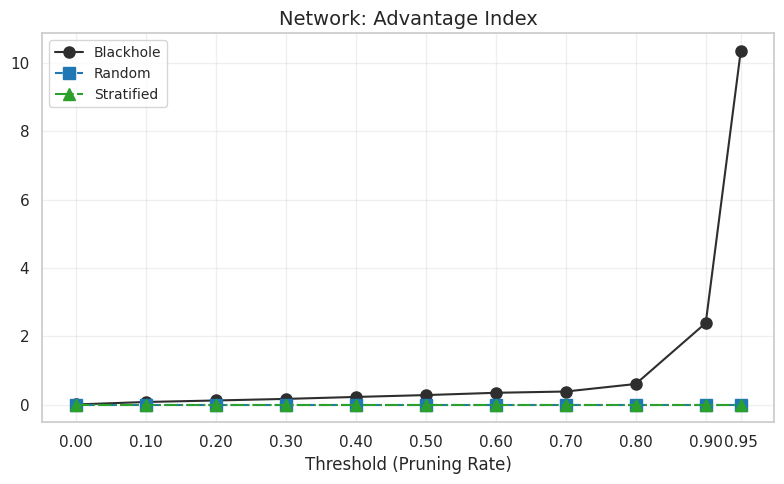

Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)
                     Accuracy_mean                     Accuracy_sem            \
Model                          GAT       GCN GraphSAGE          GAT       GCN   
Threshold Method                                                                
0.00      blackhole       0.632276  0.606623  0.621252     0.019801  0.005406   
          random          0.623554  0.636047  0.615361     0.033146  0.007119   
          stratified      0.628361  0.571482  0.590799     0.009908  0.040462   
0.10      blackhole       0.610504  0.589998  0.613507     0.022096  0.007030   
          random          0.603538  0.536744  0.589275     0.019683  0.008544   
          stratified      0.619649  0.608024  0.594375     0.023806  0.045912   
0.20      blackhole       0.618833  0.559026  0.603605     0.016400  0.045665   
          random          0.603589  0.539404  0.581237     0.016604  0.004493   
          stratified      0.599908  0.581256  0.593579

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set Seaborn style
sns.set(style="whitegrid", context="notebook", palette="deep")

# Define consistent method colors, styles, and markers
method_colors = {
    'blackhole': '#2E2E2E',  # Dark gray for blackhole
    'random': '#1F77B4',     # Blue for random
    'stratified': '#2CA02C'  # Green for stratified
}
method_styles = {
    'blackhole': '-',
    'random': '--',
    'stratified': '-.'
}
method_markers = {
    'blackhole': 'o',
    'random': 's',
    'stratified': '^'
}

output_dir = 'plots_Comparision'
os.makedirs(output_dir, exist_ok=True)

# Load data
df = pd.read_csv('https://raw.githubusercontent.com/MehrdadJalali-AI/BlackHole/main/evaluation_results/model_results_with_error_bars.csv')

# Calculate SEM (assuming num_runs=1 as per main.py)
df['Accuracy_sem'] = df['Accuracy_std'] / np.sqrt(1)
df['Cohen_Kappa_sem'] = df['Cohen_Kappa_std'] / np.sqrt(1)

# Compute Advantage Index
def calculate_advantage_index(df):
    df = df.copy()
    # Baseline values at threshold 0.0 for normalization
    # Use numeric_only=True to exclude non-numeric columns like 'Model'
    baseline = df[df['Threshold'] == 0.0].groupby('Method').mean(numeric_only=True)
    weights = {'Accuracy_mean': 0.4, 'Modularity_mean': 0.3, 'Graph_Density_mean': 0.3}
    df['Advantage_Index'] = 0.0

    for thresh in df['Threshold'].unique():
        for model in df['Model'].unique():
            subset = df[(df['Threshold'] == thresh) & (df['Model'] == model)]
            if not subset.empty:
                bh_data = subset[subset['Method'] == 'blackhole']
                rand_data = subset[subset['Method'] == 'random']
                strat_data = subset[subset['Method'] == 'stratified']

                if not (bh_data.empty or rand_data.empty or strat_data.empty):
                    bh_vals = bh_data[['Accuracy_mean', 'Modularity_mean', 'Graph_Density_mean']].iloc[0]
                    rand_vals = rand_data[['Accuracy_mean', 'Modularity_mean', 'Graph_Density_mean']].iloc[0]
                    strat_vals = strat_data[['Accuracy_mean', 'Modularity_mean', 'Graph_Density_mean']].iloc[0]
                    base_bh = baseline.loc['blackhole', ['Accuracy_mean', 'Modularity_mean', 'Graph_Density_mean']]
                    base_rand = baseline.loc['random', ['Accuracy_mean', 'Modularity_mean', 'Graph_Density_mean']]
                    base_strat = baseline.loc['stratified', ['Accuracy_mean', 'Modularity_mean', 'Graph_Density_mean']]

                    advantage = 0.0
                    for metric in weights.keys():
                        bh_val = bh_vals[metric]
                        rand_val = rand_vals[metric]
                        strat_val = strat_vals[metric]
                        base_bh_val = base_bh[metric]
                        base_rand_val = base_rand[metric]
                        base_strat_val = base_strat[metric]

                        # Normalize differences
                        norm_bh_rand = (bh_val - rand_val) / base_bh_val if base_bh_val != 0 else (bh_val - rand_val)
                        norm_bh_strat = (bh_val - strat_val) / base_bh_val if base_bh_val != 0 else (bh_val - strat_val)
                        # Average normalized advantage
                        metric_advantage = (norm_bh_rand + norm_bh_strat) / 2
                        advantage += weights[metric] * metric_advantage

                    df.loc[(df['Threshold'] == thresh) & (df['Method'] == 'blackhole') & (df['Model'] == model), 'Advantage_Index'] = advantage
    return df

df = calculate_advantage_index(df)

# Metrics and corresponding stds
performance_metrics = [
    ('Accuracy_mean', 'Accuracy_sem'),
    ('Cohen_Kappa_mean', 'Cohen_Kappa_sem')
]
network_metrics = [
    ('Modularity_mean', 'Modularity_std'),
    ('Num_Communities_mean', 'Num_Communities_std'),
    ('Avg_Community_Size_mean', 'Avg_Community_Size_std'),
    ('Avg_Clustering_mean', 'Avg_Clustering_std'),
    ('Graph_Density_mean', 'Graph_Density_std'),
    ('Avg_Degree_mean', 'Avg_Degree_std'),
    ('Advantage_Index', None)  # No SEM for derived index
]

# Models and thresholds
models = df['Model'].unique()
threshold_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

# Filter dataframe to only include specified thresholds
df = df[df['Threshold'].isin(threshold_values)]

# Font sizes
label_fontsize = 12
tick_fontsize = 11
title_fontsize = 14
legend_fontsize = 10

# Function to check for significant outperformance
def is_significant(bh_mean, bh_sem, other_mean, other_sem):
    return bh_mean - bh_sem > other_mean + other_sem

# Plotting function for combined comparisons
def plot_comparison(subset, metric, std_metric, title_prefix):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx() if metric in ['Accuracy_mean', 'Cohen_Kappa_mean'] else None

    # Plot data for each method
    methods = ['blackhole', 'random', 'stratified']
    for method in methods:
        method_data = subset[subset['Method'] == method].sort_values('Threshold')
        ax.plot(method_data['Threshold'], method_data[metric],
                label=f'{method.title()}',
                color=method_colors[method], linestyle=method_styles[method],
                marker=method_markers[method], markersize=8)
        if std_metric:
            ax.fill_between(method_data['Threshold'],
                            method_data[metric] - method_data[std_metric],
                            method_data[metric] + method_data[std_metric],
                            alpha=0.15, color=method_colors[method])

    # Add Graph Density on secondary y-axis for Accuracy and Cohen's Kappa
    if metric in ['Accuracy_mean', 'Cohen_Kappa_mean']:
        density_data = subset[subset['Method'] == 'blackhole'].sort_values('Threshold')
        ax2.plot(density_data['Threshold'], density_data['Graph_Density_mean'],
                 color='purple', linestyle=':', label='Graph Density (BH)', alpha=0.7)
        ax2.set_yscale('log')
        ax2.set_ylabel('Graph Density (Log Scale)', fontsize=label_fontsize, color='purple')
        ax2.tick_params(axis='y', labelsize=tick_fontsize, labelcolor='purple')

    # Annotations for significant outperformance (Accuracy only)
    if metric == 'Accuracy_mean':
        for thresh in threshold_values:
            bh_data = subset[(subset['Method'] == 'blackhole') & (subset['Threshold'] == thresh)]
            rand_data = subset[(subset['Method'] == 'random') & (subset['Threshold'] == thresh)]
            strat_data = subset[(subset['Method'] == 'stratified') & (subset['Threshold'] == thresh)]
            if not (bh_data.empty or rand_data.empty or strat_data.empty):
                bh_acc, bh_sem = bh_data['Accuracy_mean'].values[0], bh_data['Accuracy_sem'].values[0]
                rand_acc, rand_sem = rand_data['Accuracy_mean'].values[0], rand_data['Accuracy_sem'].values[0]
                strat_acc, strat_sem = strat_data['Accuracy_mean'].values[0], strat_data['Accuracy_sem'].values[0]
                if is_significant(bh_acc, bh_sem, rand_acc, rand_sem) and \
                   is_significant(bh_acc, bh_sem, strat_acc, strat_sem):
                    ax.annotate('*', xy=(thresh, bh_acc), xytext=(0, 5),
                               textcoords='offset points', ha='center', color='red', fontsize=12)

    # Customize plot
    metric_name = metric.replace("_mean", "").replace("_", " ").title()
    ax.set_title(f'{title_prefix}: {metric_name}', fontsize=title_fontsize)
    ax.set_xlabel('Threshold (Pruning Rate)', fontsize=label_fontsize)
    ax.set_xticks(threshold_values)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(True, alpha=0.3)

    # Adjust y-axis for Graph Density
    if metric == 'Graph_Density_mean':
        ax.set_yscale('log')

    # Combine legends
    if ax2:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, fontsize=legend_fontsize, loc='upper left')
    else:
        ax.legend(fontsize=legend_fontsize, loc='best')

    # Save plot
    metric_safe = metric.replace('_', '-')
    filename = f'{title_prefix.lower()}-{metric_safe}'
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate plots for performance metrics (model-dependent)
for model in models:
    subset = df[df['Model'] == model]
    for metric, std_metric in performance_metrics:
        plot_comparison(subset, metric, std_metric, model)

# Generate plots for network metrics (model-independent, using GAT data)
subset = df[df['Model'] == 'GAT']
for metric, std_metric in network_metrics:
    plot_comparison(subset, metric, std_metric, 'Network')

# Calculate maximum and minimum distances of BH Accuracy from Random and Stratified
distances_bh_random = []
distances_bh_stratified = []

for thresh in threshold_values:
    for model in models:
        bh_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        rand_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'random') & (df['Model'] == model)]
        strat_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or rand_data.empty or strat_data.empty):
            bh_acc = bh_data['Accuracy_mean'].values[0]
            rand_acc = rand_data['Accuracy_mean'].values[0]
            strat_acc = strat_data['Accuracy_mean'].values[0]
            dist_bh_random = bh_acc - rand_acc
            dist_bh_stratified = bh_acc - strat_acc
            distances_bh_random.append((dist_bh_random, thresh, model, bh_acc, rand_acc))
            distances_bh_stratified.append((dist_bh_stratified, thresh, model, bh_acc, strat_acc))

# Find maximum and minimum distances
max_dist_bh_random = max(distances_bh_random, key=lambda x: x[0])
min_dist_bh_random = min(distances_bh_random, key=lambda x: x[0])
max_dist_bh_stratified = max(distances_bh_stratified, key=lambda x: x[0])
min_dist_bh_stratified = min(distances_bh_stratified, key=lambda x: x[0])

# Summary Table for Performance Metrics
print("Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)")
summary_table = df.pivot_table(
    index=['Threshold', 'Method'],
    columns='Model',
    values=['Accuracy_mean', 'Accuracy_sem', 'Cohen_Kappa_mean', 'Cohen_Kappa_sem'],
    aggfunc='first'
)
print(summary_table)

# Summary Table for Network Metrics (using GAT data as representative)
print("\nSummary Table: Network Metrics (Mean ± Std)")
network_summary_table = df[df['Model'] == 'GAT'].pivot_table(
    index=['Threshold', 'Method'],
    values=[metric for metric, _ in network_metrics],
    aggfunc='first'
)
print(network_summary_table)

# Key Findings
print("\nKey Findings:")
# Significant outperformance
bh_outperform = []
for thresh in threshold_values:
    for model in models:
        bh_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        rand_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'random') & (df['Model'] == model)]
        strat_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or rand_data.empty or strat_data.empty):
            bh_acc, bh_sem = bh_data['Accuracy_mean'].values[0], bh_data['Accuracy_sem'].values[0]
            rand_acc, rand_sem = rand_data['Accuracy_mean'].values[0], rand_data['Accuracy_sem'].values[0]
            strat_acc, strat_sem = strat_data['Accuracy_mean'].values[0], strat_data['Accuracy_sem'].values[0]
            if is_significant(bh_acc, bh_sem, rand_acc, rand_sem) and \
               is_significant(bh_acc, bh_sem, strat_acc, strat_sem):
                bh_outperform.append((thresh, model, bh_acc, rand_acc, strat_acc))

if bh_outperform:
    print("Thresholds where Blackhole significantly outperforms both Random and Stratified (Accuracy):")
    for thresh, model, bh_acc, rand_acc, strat_acc in bh_outperform:
        print(f"- Threshold {thresh:.2f}, Model {model}: BH Accuracy = {bh_acc:.4f}, "
              f"Random = {rand_acc:.4f}, Stratified = {strat_acc:.4f}")
else:
    print("- No thresholds where Blackhole significantly outperforms both Random and Stratified.")

# Maximum and Minimum Distances
print("\nMaximum and Minimum Distances of Blackhole Accuracy from Random and Stratified:")
print("Blackhole vs Random:")
print(f"- Maximum Distance: {max_dist_bh_random[0]:.4f} at Threshold {max_dist_bh_random[1]:.2f}, Model {max_dist_bh_random[2]} "
      f"(BH Accuracy = {max_dist_bh_random[3]:.4f}, Random Accuracy = {max_dist_bh_random[4]:.4f})")
print(f"- Minimum Distance: {min_dist_bh_random[0]:.4f} at Threshold {min_dist_bh_random[1]:.2f}, Model {max_dist_bh_random[2]} "
      f"(BH Accuracy = {min_dist_bh_random[3]:.4f}, Random Accuracy = {min_dist_bh_random[4]:.4f})")
print("Blackhole vs Stratified:")
print(f"- Maximum Distance: {max_dist_bh_stratified[0]:.4f} at Threshold {max_dist_bh_stratified[1]:.2f}, Model {max_dist_bh_stratified[2]} "
      f"(BH Accuracy = {max_dist_bh_stratified[3]:.4f}, Stratified Accuracy = {max_dist_bh_stratified[4]:.4f})")
print(f"- Minimum Distance: {min_dist_bh_stratified[0]:.4f} at Threshold {min_dist_bh_stratified[1]:.2f}, Model {min_dist_bh_stratified[2]} "
      f"(BH Accuracy = {min_dist_bh_stratified[3]:.4f}, Stratified Accuracy = {min_dist_bh_stratified[4]:.4f})")

# Highlight highest accuracy
max_acc_row = df.loc[df['Accuracy_mean'].idxmax()]
print(f"\nHighest Accuracy: {max_acc_row['Accuracy_mean']:.4f} by {max_acc_row['Model']} "
      f"({max_acc_row['Method']}) at Threshold {max_acc_row['Threshold']:.2f}, "
      f"with Graph Density = {max_acc_row['Graph_Density_mean']:.6f}, "
      f"Advantage Index = {max_acc_row['Advantage_Index']:.4f}")


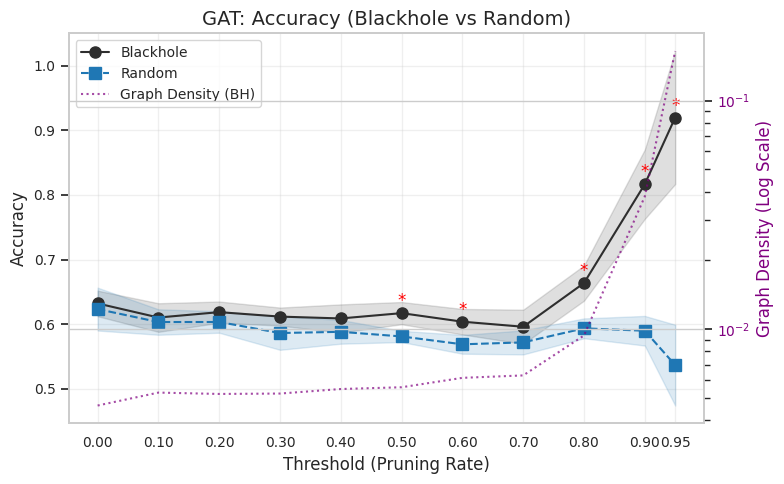

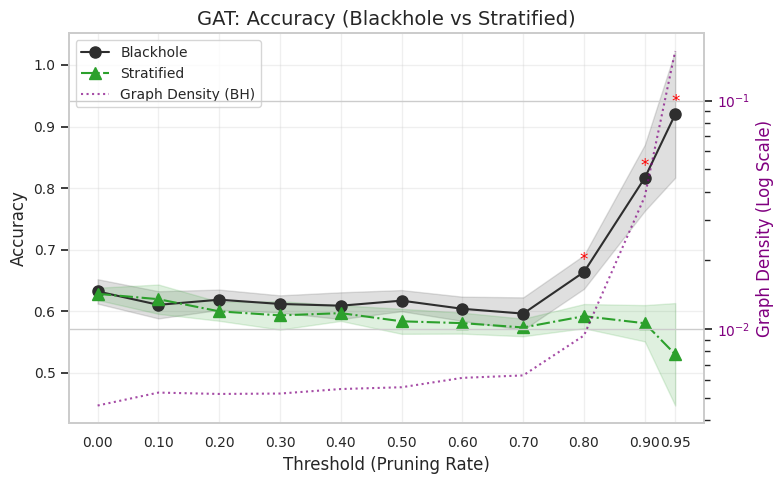

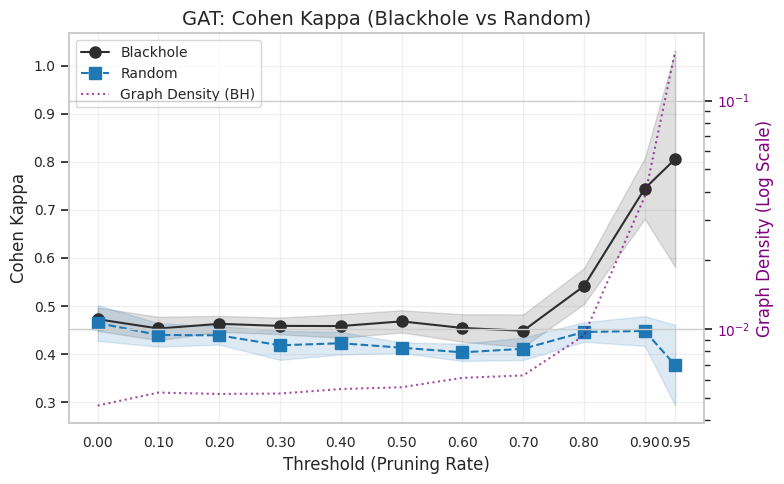

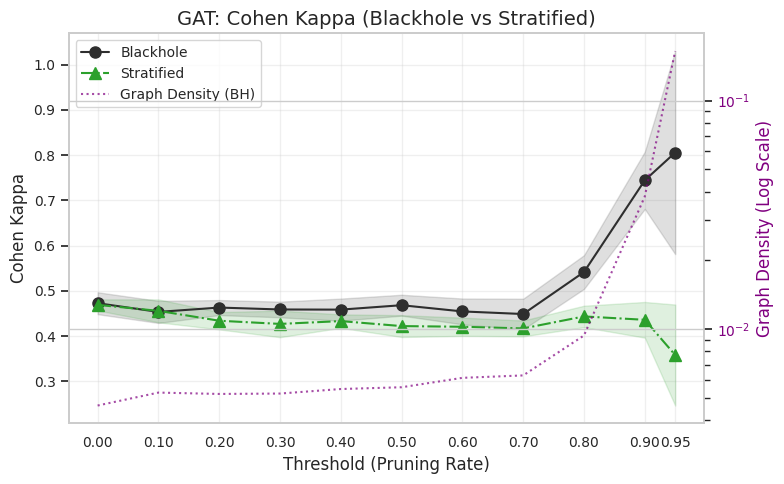

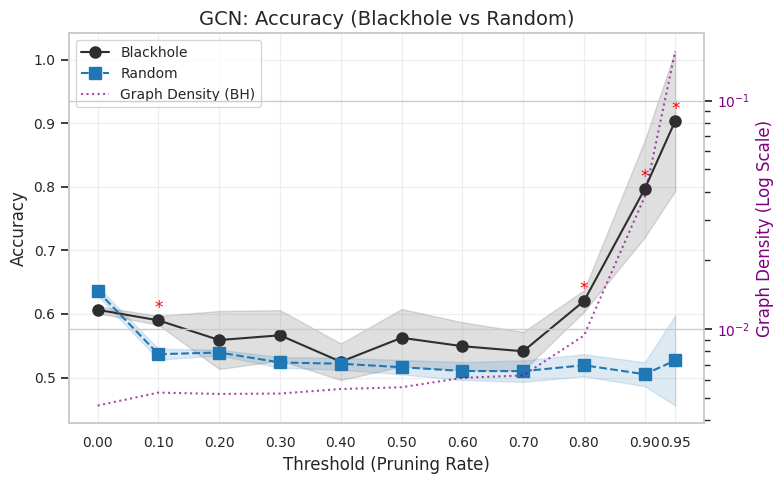

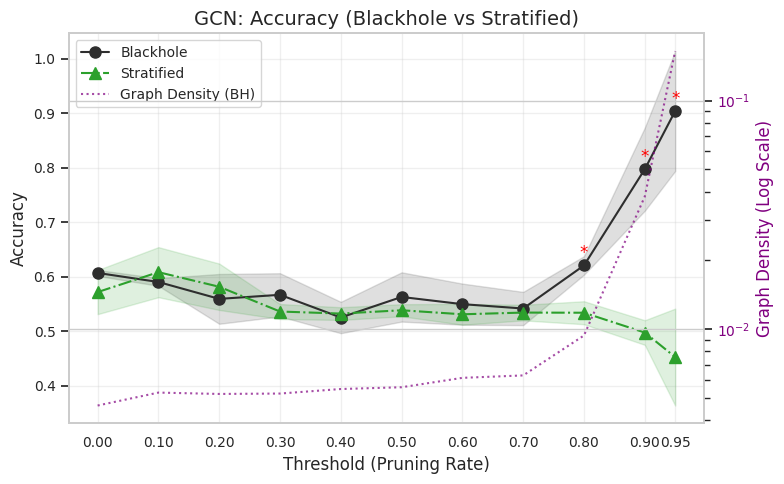

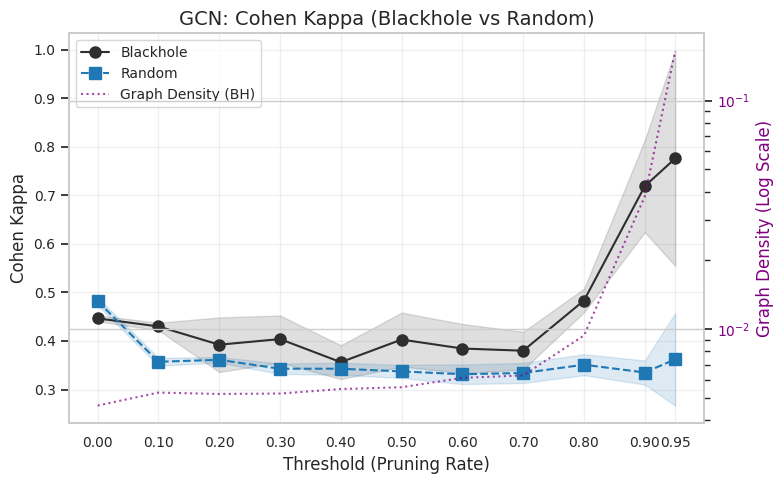

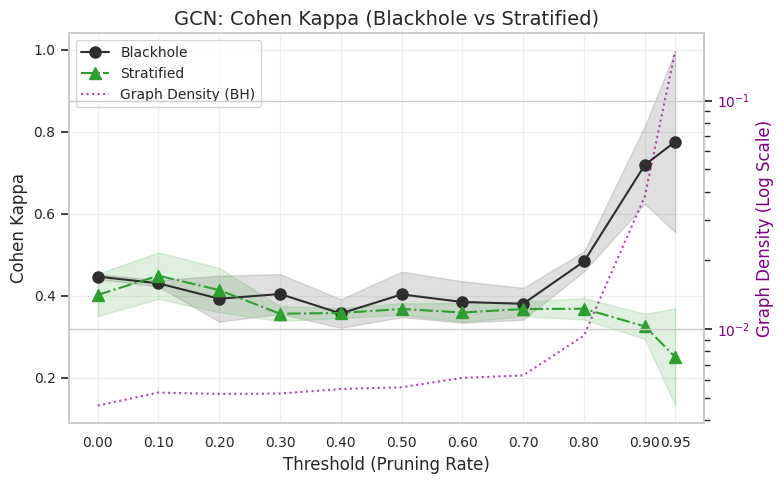

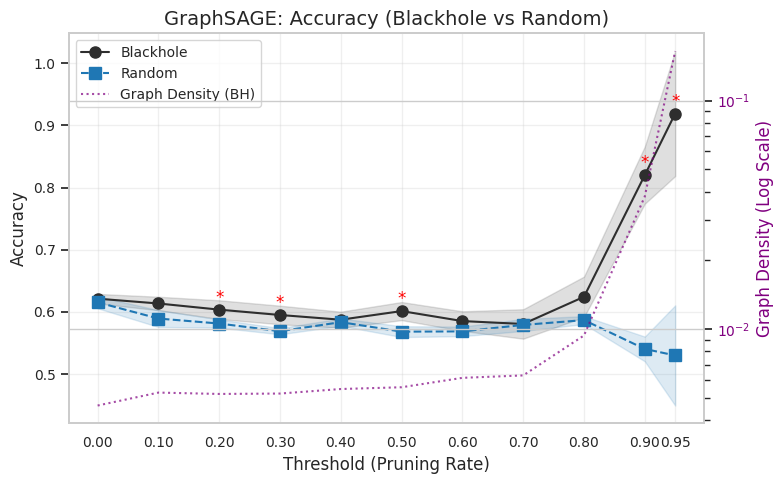

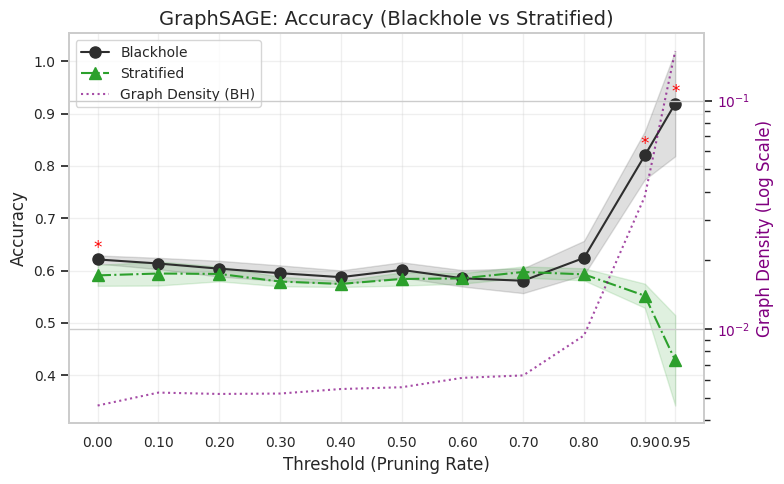

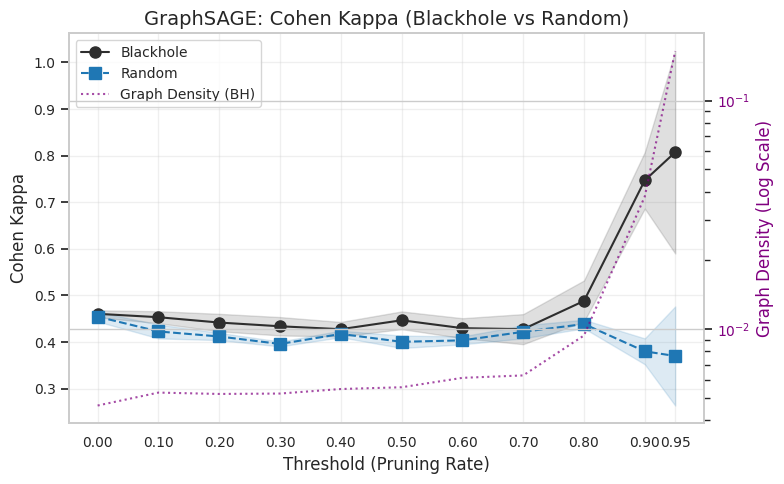

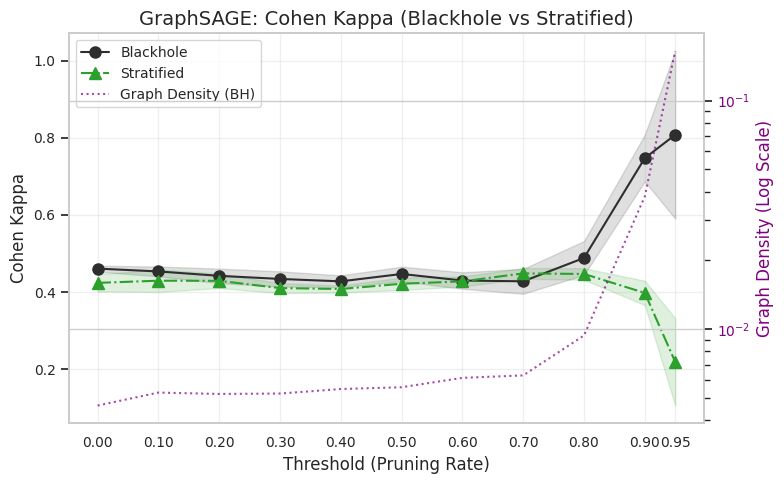

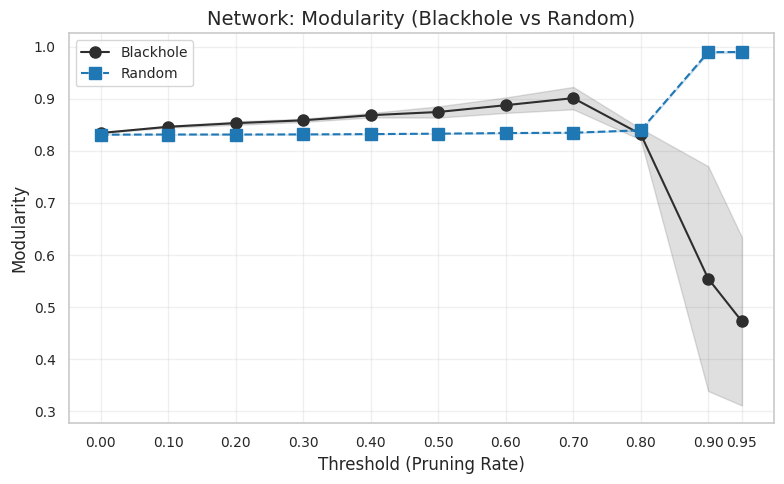

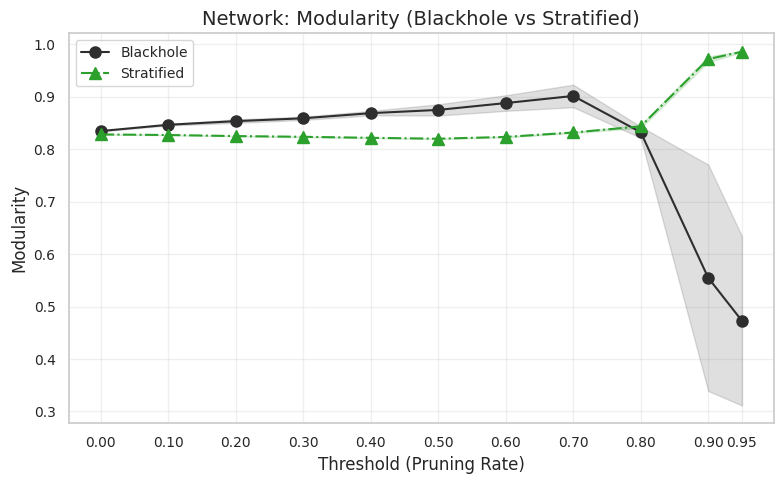

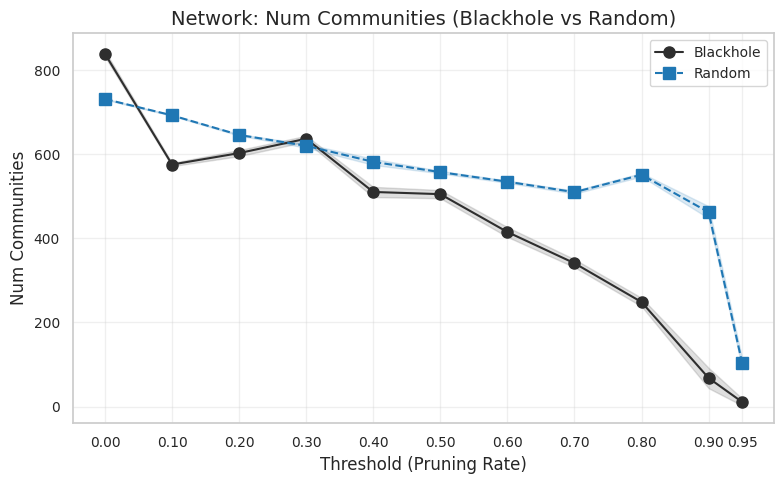

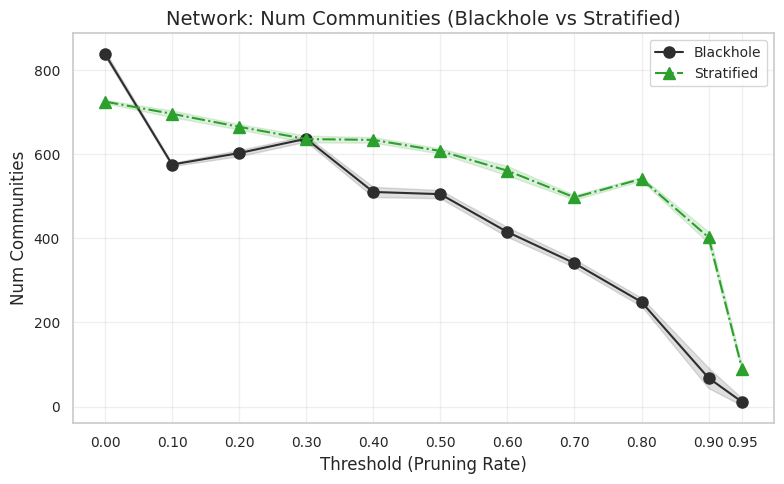

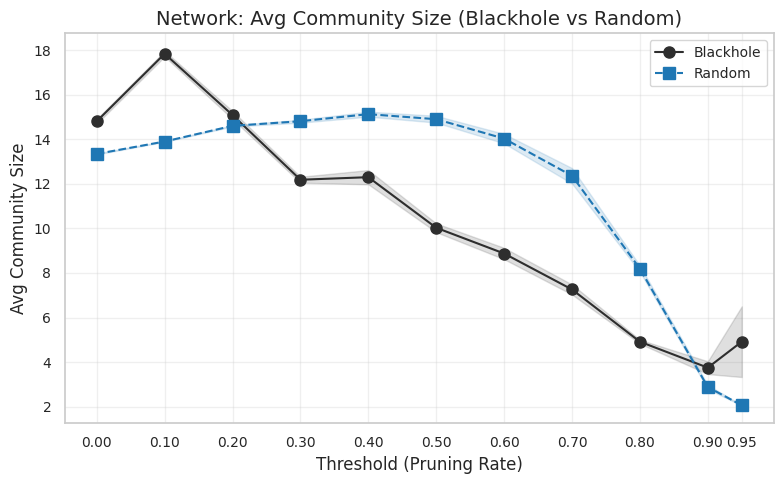

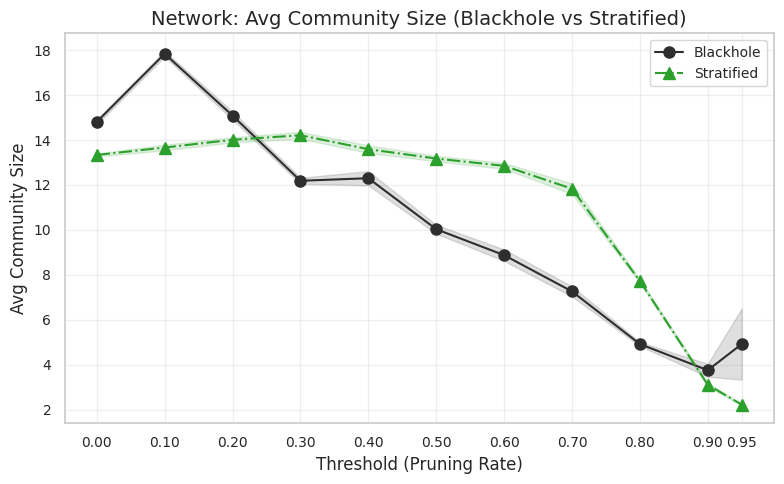

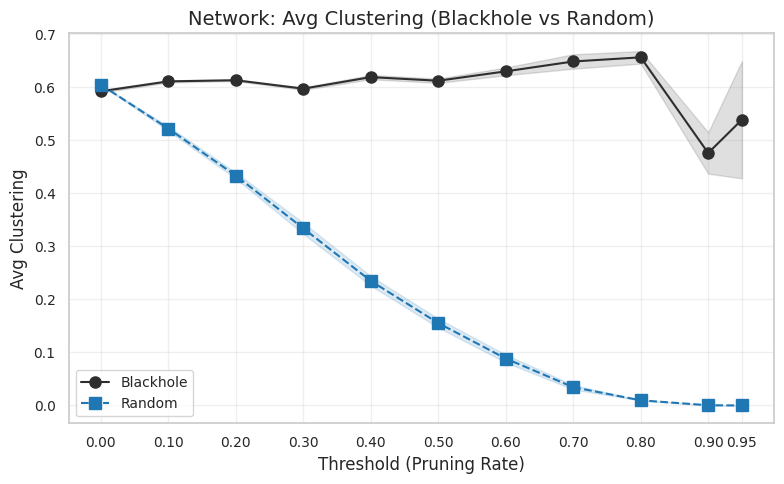

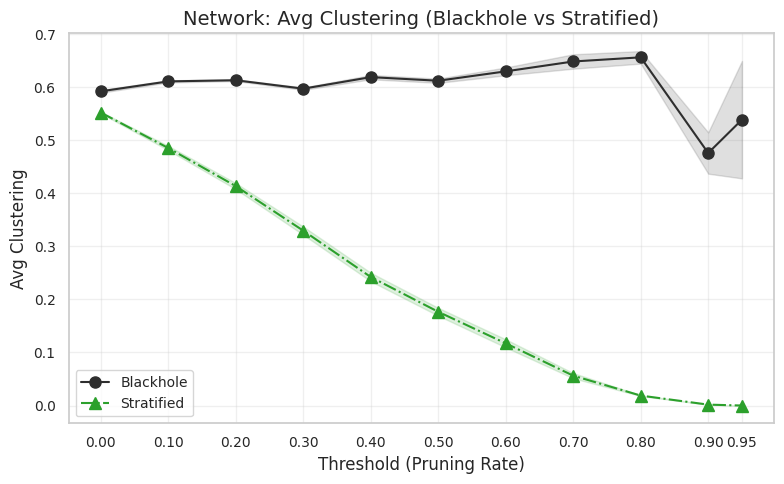

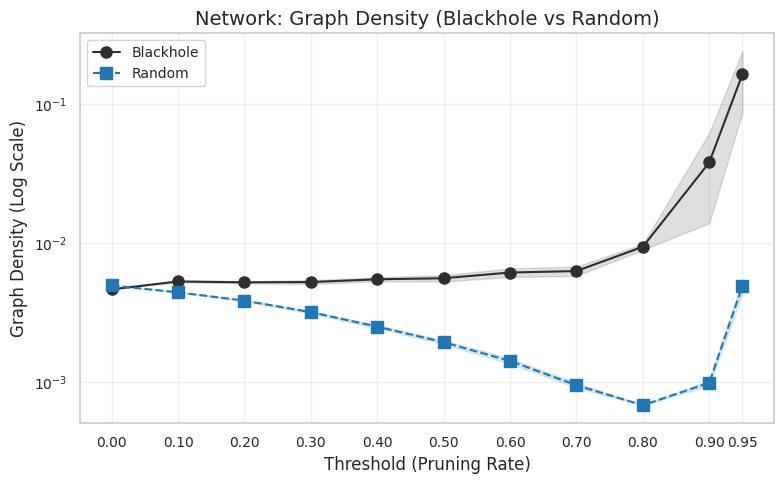

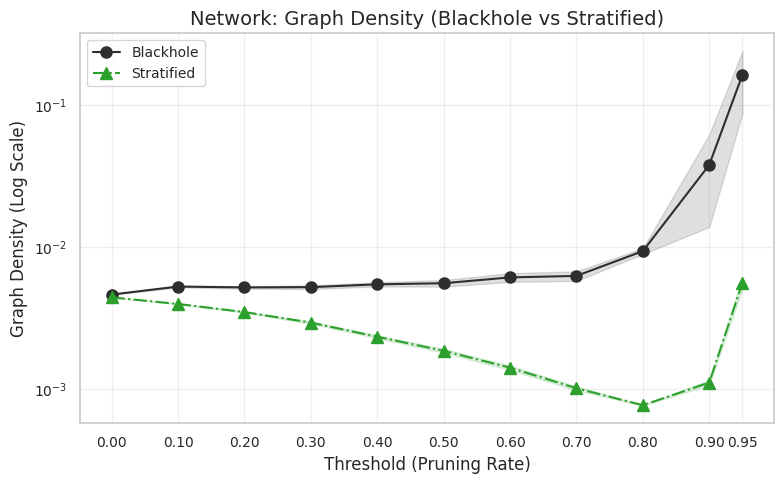

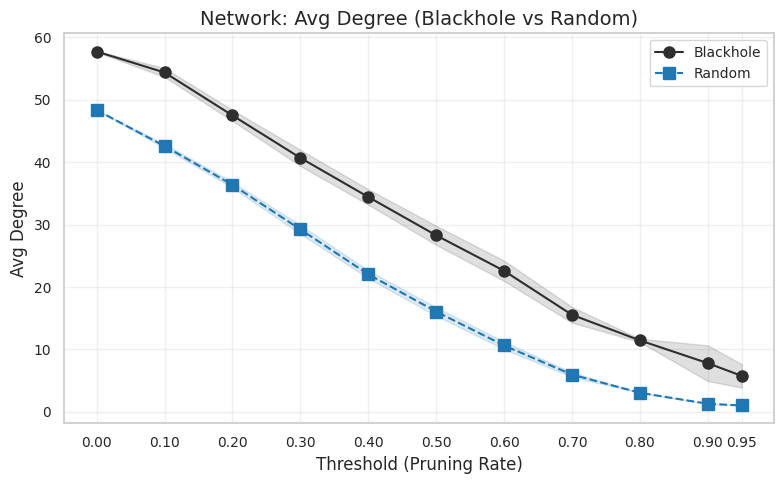

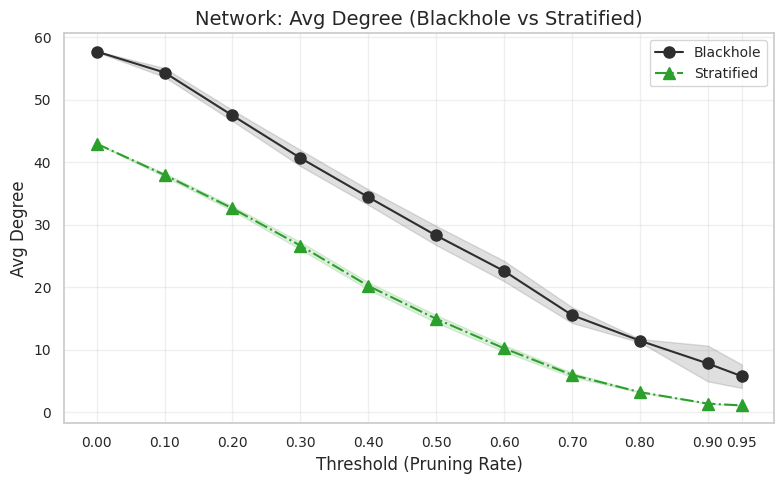

Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)
                     Accuracy_mean                     Accuracy_sem            \
Model                          GAT       GCN GraphSAGE          GAT       GCN   
Threshold Method                                                                
0.00      blackhole       0.632276  0.606623  0.621252     0.019801  0.005406   
          random          0.623554  0.636047  0.615361     0.033146  0.007119   
          stratified      0.628361  0.571482  0.590799     0.009908  0.040462   
0.10      blackhole       0.610504  0.589998  0.613507     0.022096  0.007030   
          random          0.603538  0.536744  0.589275     0.019683  0.008544   
          stratified      0.619649  0.608024  0.594375     0.023806  0.045912   
0.20      blackhole       0.618833  0.559026  0.603605     0.016400  0.045665   
          random          0.603589  0.539404  0.581237     0.016604  0.004493   
          stratified      0.599908  0.581256  0.593579

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set Seaborn style
sns.set(style="whitegrid", context="notebook", palette="deep")

# Define consistent method colors, styles, and markers
method_colors = {
    'blackhole': '#2E2E2E',  # Dark gray for blackhole
    'random': '#1F77B4',     # Blue for random
    'stratified': '#2CA02C'  # Green for stratified
}
method_styles = {
    'blackhole': '-',
    'random': '--',
    'stratified': '-.'
}
method_markers = {
    'blackhole': 'o',
    'random': 's',
    'stratified': '^'
}

# Create plots directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

# Load data
df = pd.read_csv('https://raw.githubusercontent.com/MehrdadJalali-AI/BlackHole/main/evaluation_results/model_results_with_error_bars.csv')

# Calculate SEM (assuming num_runs=1 as per main.py)
df['Accuracy_sem'] = df['Accuracy_std'] / np.sqrt(1)
df['Cohen_Kappa_sem'] = df['Cohen_Kappa_std'] / np.sqrt(1)

# Metrics and corresponding stds
performance_metrics = [
    ('Accuracy_mean', 'Accuracy_sem'),
    ('Cohen_Kappa_mean', 'Cohen_Kappa_sem')
]
network_metrics = [
    ('Modularity_mean', 'Modularity_std'),
    ('Num_Communities_mean', 'Num_Communities_std'),
    ('Avg_Community_Size_mean', 'Avg_Community_Size_std'),
    ('Avg_Clustering_mean', 'Avg_Clustering_std'),
    ('Graph_Density_mean', 'Graph_Density_std'),
    ('Avg_Degree_mean', 'Avg_Degree_std')
]

# Models and thresholds
models = df['Model'].unique()
threshold_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

# Filter dataframe to only include specified thresholds
df = df[df['Threshold'].isin(threshold_values)]

# Font sizes
label_fontsize = 12
tick_fontsize = 10
title_fontsize = 14
legend_fontsize = 10

# Function to check for significant outperformance
def is_significant(bh_mean, bh_sem, other_mean, other_sem):
    return bh_mean - bh_sem > other_mean + other_sem

# Plotting function for pairwise comparisons
def plot_pairwise_comparison(subset, metric, std_metric, title_prefix, methods, comparison_name):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx() if metric in ['Accuracy_mean', 'Cohen_Kappa_mean'] else None

    # Plot data for each method
    for method in methods:
        method_data = subset[subset['Method'] == method].sort_values('Threshold')
        ax.plot(method_data['Threshold'], method_data[metric],
                label=f'{method.title()}',
                color=method_colors[method], linestyle=method_styles[method],
                marker=method_markers[method], markersize=8)
        ax.fill_between(method_data['Threshold'],
                        method_data[metric] - method_data[std_metric],
                        method_data[metric] + method_data[std_metric],
                        alpha=0.15, color=method_colors[method])

    # Add Graph Density on secondary y-axis for Accuracy and Cohen's Kappa
    if metric in ['Accuracy_mean', 'Cohen_Kappa_mean']:
        density_data = subset[subset['Method'] == 'blackhole'].sort_values('Threshold')
        ax2.plot(density_data['Threshold'], density_data['Graph_Density_mean'],
                 color='purple', linestyle=':', label='Graph Density (BH)', alpha=0.7)
        ax2.set_yscale('log')
        ax2.set_ylabel('Graph Density (Log Scale)', fontsize=label_fontsize, color='purple')
        ax2.tick_params(axis='y', labelsize=tick_fontsize, labelcolor='purple')

    # Annotations for significant outperformance (Accuracy only)
    if metric == 'Accuracy_mean':
        for thresh in threshold_values:
            bh_data = subset[(subset['Method'] == 'blackhole') & (subset['Threshold'] == thresh)]
            other_data = subset[(subset['Method'] == methods[1]) & (subset['Threshold'] == thresh)]
            if not (bh_data.empty or other_data.empty):
                bh_acc, bh_sem = bh_data['Accuracy_mean'].values[0], bh_data['Accuracy_sem'].values[0]
                other_acc, other_sem = other_data['Accuracy_mean'].values[0], other_data[std_metric].values[0]
                if is_significant(bh_acc, bh_sem, other_acc, other_sem):
                    ax.annotate('*', xy=(thresh, bh_acc), xytext=(0, 5),
                               textcoords='offset points', ha='center', color='red', fontsize=12)

    # Customize plot
    metric_name = metric.replace("_mean", "").replace("_", " ").title()
    ax.set_title(f'{title_prefix}: {metric_name} ({comparison_name})', fontsize=title_fontsize)
    ax.set_xlabel('Threshold (Pruning Rate)', fontsize=label_fontsize)
    ax.set_ylabel(metric_name, fontsize=label_fontsize)
    ax.set_xticks(threshold_values)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(True, alpha=0.3)

    # Adjust y-axis for Graph Density
    if metric == 'Graph_Density_mean':
        ax.set_yscale('log')
        ax.set_ylabel('Graph Density (Log Scale)', fontsize=label_fontsize)

    # Combine legends
    if ax2:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, fontsize=legend_fontsize, loc='upper left')
    else:
        ax.legend(fontsize=legend_fontsize, loc='best')

    # Save plot
    metric_safe = metric.replace('_', '-')
    filename = f'{title_prefix.lower()}-{metric_safe}-{comparison_name.lower().replace(" ", "-")}'
    plt.tight_layout()
    plt.savefig(f'plots/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate plots for performance metrics (model-dependent)
for model in models:
    subset = df[df['Model'] == model]
    for metric, std_metric in performance_metrics:
        # Blackhole vs Random
        plot_pairwise_comparison(
            subset[subset['Method'].isin(['blackhole', 'random'])],
            metric, std_metric, model, ['blackhole', 'random'], 'Blackhole vs Random'
        )
        # Blackhole vs Stratified
        plot_pairwise_comparison(
            subset[subset['Method'].isin(['blackhole', 'stratified'])],
            metric, std_metric, model, ['blackhole', 'stratified'], 'Blackhole vs Stratified'
        )

# Generate plots for network metrics (model-independent, using GAT data)
subset = df[df['Model'] == 'GAT']
for metric, std_metric in network_metrics:
    # Blackhole vs Random
    plot_pairwise_comparison(
        subset[subset['Method'].isin(['blackhole', 'random'])],
        metric, std_metric, 'Network', ['blackhole', 'random'], 'Blackhole vs Random'
    )
    # Blackhole vs Stratified
    plot_pairwise_comparison(
        subset[subset['Method'].isin(['blackhole', 'stratified'])],
        metric, std_metric, 'Network', ['blackhole', 'stratified'], 'Blackhole vs Stratified'
    )

# Calculate maximum and minimum distances of BH Accuracy from Random and Stratified
distances_bh_random = []
distances_bh_stratified = []

for thresh in threshold_values:
    for model in models:
        bh_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        rand_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'random') & (df['Model'] == model)]
        strat_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or rand_data.empty or strat_data.empty):
            bh_acc = bh_data['Accuracy_mean'].values[0]
            rand_acc = rand_data['Accuracy_mean'].values[0]
            strat_acc = strat_data['Accuracy_mean'].values[0]
            dist_bh_random = bh_acc - rand_acc
            dist_bh_stratified = bh_acc - strat_acc
            distances_bh_random.append((dist_bh_random, thresh, model, bh_acc, rand_acc))
            distances_bh_stratified.append((dist_bh_stratified, thresh, model, bh_acc, strat_acc))

# Find maximum and minimum distances
max_dist_bh_random = max(distances_bh_random, key=lambda x: x[0])
min_dist_bh_random = min(distances_bh_random, key=lambda x: x[0])
max_dist_bh_stratified = max(distances_bh_stratified, key=lambda x: x[0])
min_dist_bh_stratified = min(distances_bh_stratified, key=lambda x: x[0])

# Summary Table for Performance Metrics
print("Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)")
summary_table = df.pivot_table(
    index=['Threshold', 'Method'],
    columns='Model',
    values=['Accuracy_mean', 'Accuracy_sem', 'Cohen_Kappa_mean', 'Cohen_Kappa_sem'],
    aggfunc='first'
)
print(summary_table)

# Summary Table for Network Metrics (using GAT data as representative)
print("\nSummary Table: Network Metrics (Mean ± Std)")
network_summary_table = df[df['Model'] == 'GAT'].pivot_table(
    index=['Threshold', 'Method'],
    values=[metric for metric, _ in network_metrics],
    aggfunc='first'
)
print(network_summary_table)

# Key Findings
print("\nKey Findings:")
# Significant outperformance
bh_outperform = []
for thresh in threshold_values:
    for model in models:
        bh_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        rand_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'random') & (df['Model'] == model)]
        strat_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or rand_data.empty or strat_data.empty):
            bh_acc, bh_sem = bh_data['Accuracy_mean'].values[0], bh_data['Accuracy_sem'].values[0]
            rand_acc, rand_sem = rand_data['Accuracy_mean'].values[0], rand_data['Accuracy_sem'].values[0]
            strat_acc, strat_sem = strat_data['Accuracy_mean'].values[0], strat_data['Accuracy_sem'].values[0]
            if is_significant(bh_acc, bh_sem, rand_acc, rand_sem) and \
               is_significant(bh_acc, bh_sem, strat_acc, strat_sem):
                bh_outperform.append((thresh, model, bh_acc, rand_acc, strat_acc))

if bh_outperform:
    print("Thresholds where Blackhole significantly outperforms both Random and Stratified (Accuracy):")
    for thresh, model, bh_acc, rand_acc, strat_acc in bh_outperform:
        print(f"- Threshold {thresh:.2f}, Model {model}: BH Accuracy = {bh_acc:.4f}, "
              f"Random = {rand_acc:.4f}, Stratified = {strat_acc:.4f}")
else:
    print("- No thresholds where Blackhole significantly outperforms both Random and Stratified.")

# Maximum and Minimum Distances
print("\nMaximum and Minimum Distances of Blackhole Accuracy from Random and Stratified:")
print("Blackhole vs Random:")
print(f"- Maximum Distance: {max_dist_bh_random[0]:.4f} at Threshold {max_dist_bh_random[1]:.2f}, Model {max_dist_bh_random[2]} "
      f"(BH Accuracy = {max_dist_bh_random[3]:.4f}, Random Accuracy = {max_dist_bh_random[4]:.4f})")
print(f"- Minimum Distance: {min_dist_bh_random[0]:.4f} at Threshold {min_dist_bh_random[1]:.2f}, Model {min_dist_bh_random[2]} "
      f"(BH Accuracy = {min_dist_bh_random[3]:.4f}, Random Accuracy = {min_dist_bh_random[4]:.4f})")
print("Blackhole vs Stratified:")
print(f"- Maximum Distance: {max_dist_bh_stratified[0]:.4f} at Threshold {max_dist_bh_stratified[1]:.2f}, Model {max_dist_bh_stratified[2]} "
      f"(BH Accuracy = {max_dist_bh_stratified[3]:.4f}, Stratified Accuracy = {max_dist_bh_stratified[4]:.4f})")
print(f"- Minimum Distance: {min_dist_bh_stratified[0]:.4f} at Threshold {min_dist_bh_stratified[1]:.2f}, Model {min_dist_bh_stratified[2]} "
      f"(BH Accuracy = {min_dist_bh_stratified[3]:.4f}, Stratified Accuracy = {min_dist_bh_stratified[4]:.4f})")

# Highlight highest accuracy
max_acc_row = df.loc[df['Accuracy_mean'].idxmax()]
print(f"\nHighest Accuracy: {max_acc_row['Accuracy_mean']:.4f} by {max_acc_row['Model']} "
      f"({max_acc_row['Method']}) at Threshold {max_acc_row['Threshold']:.2f}, "
      f"with Graph Density = {max_acc_row['Graph_Density_mean']:.6f}")


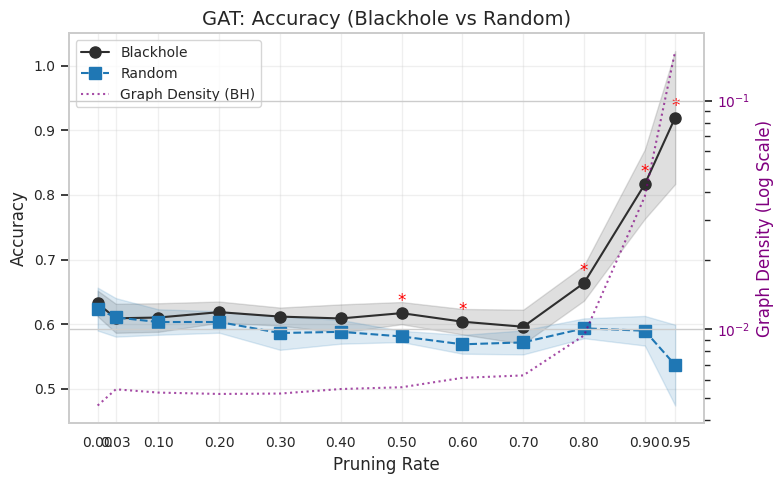

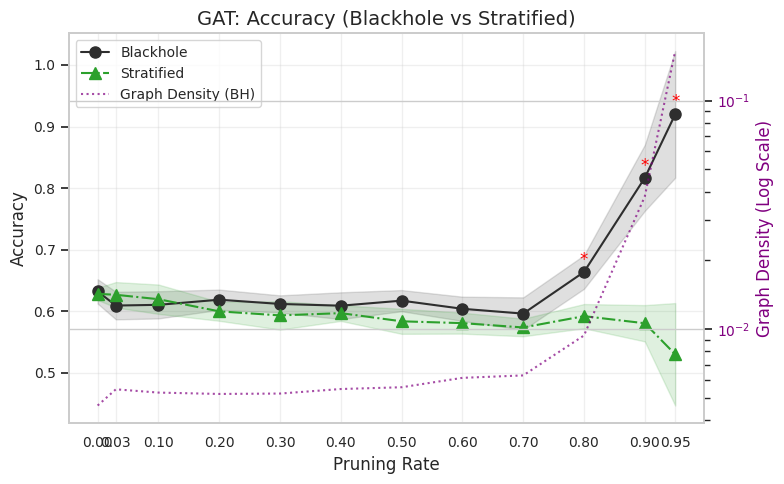

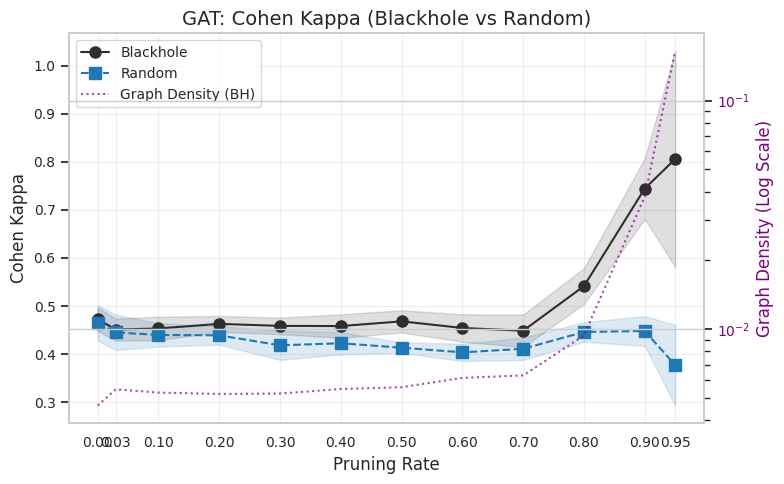

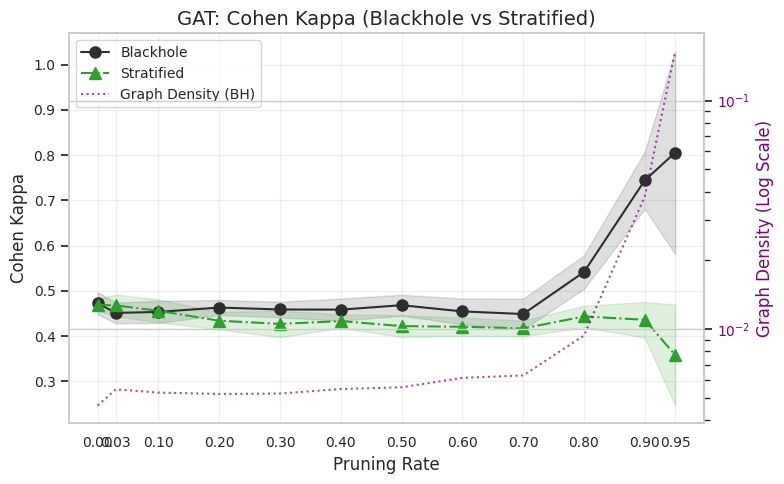

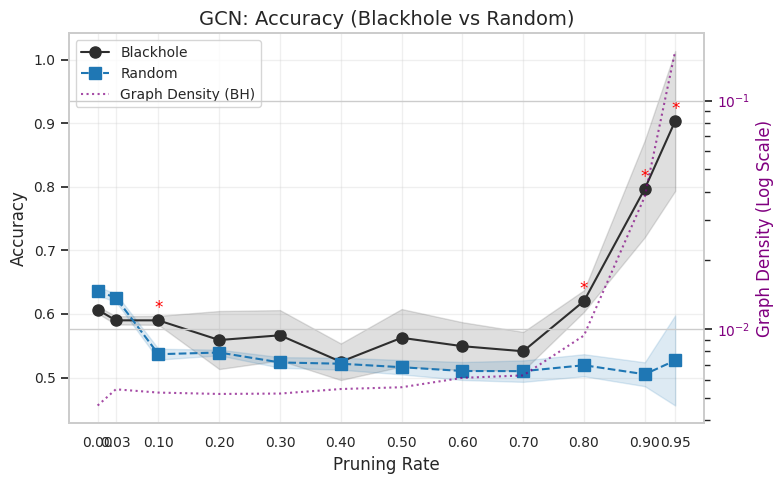

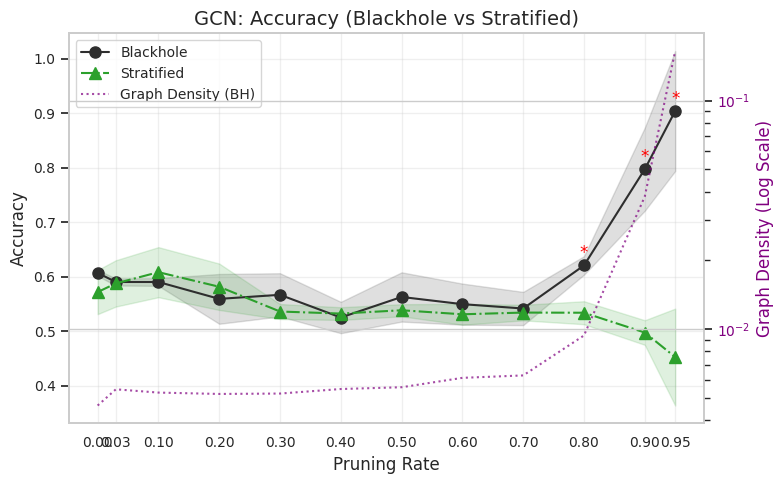

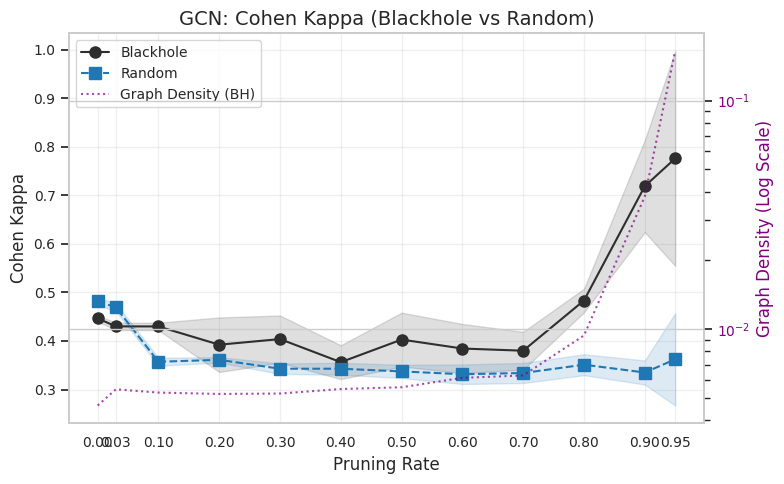

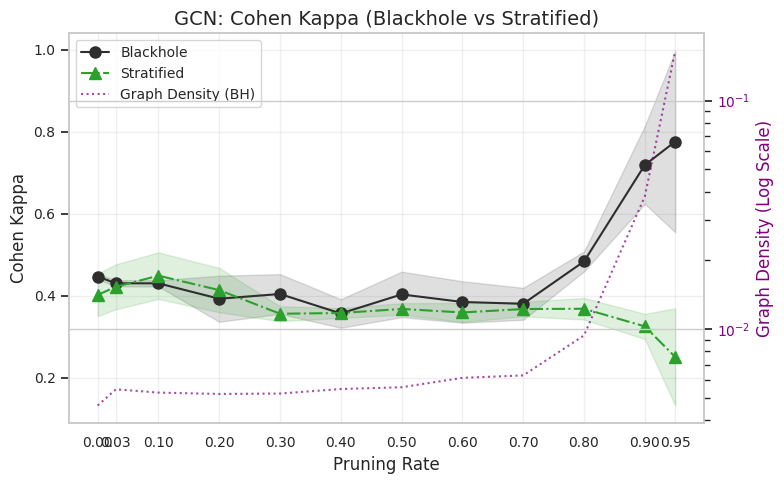

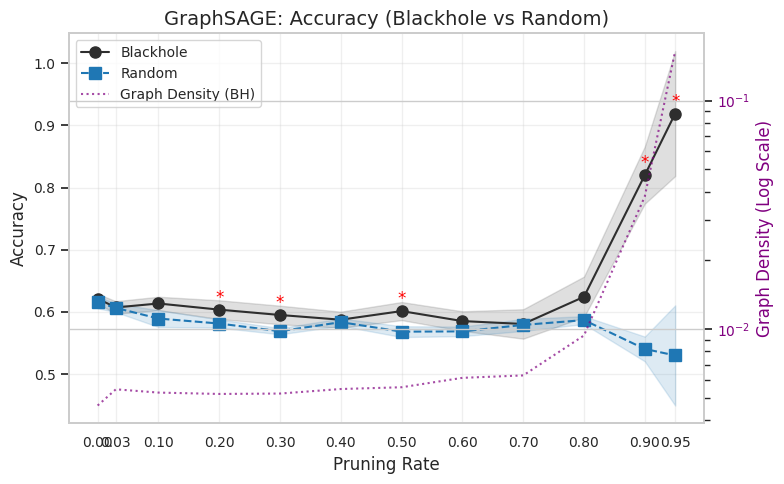

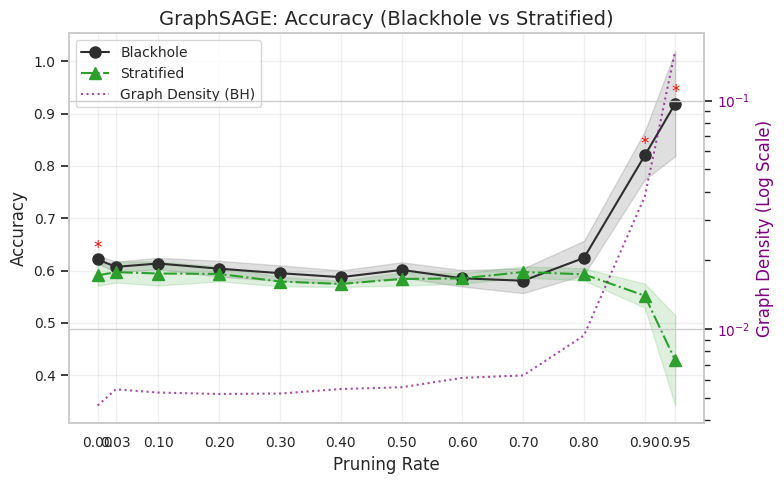

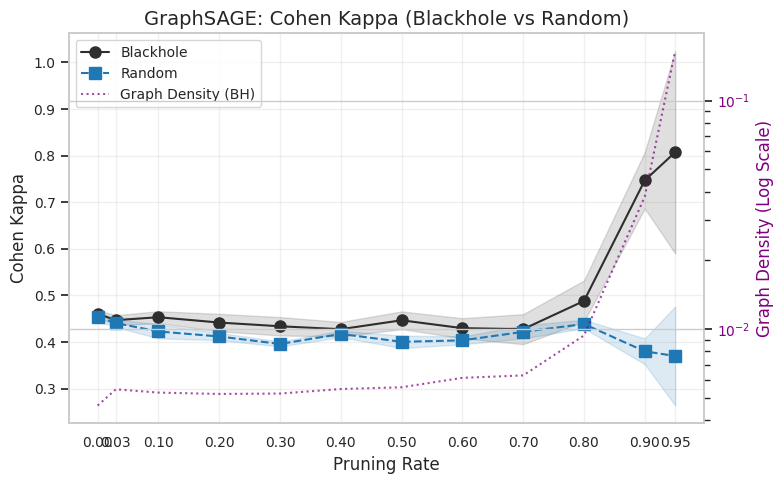

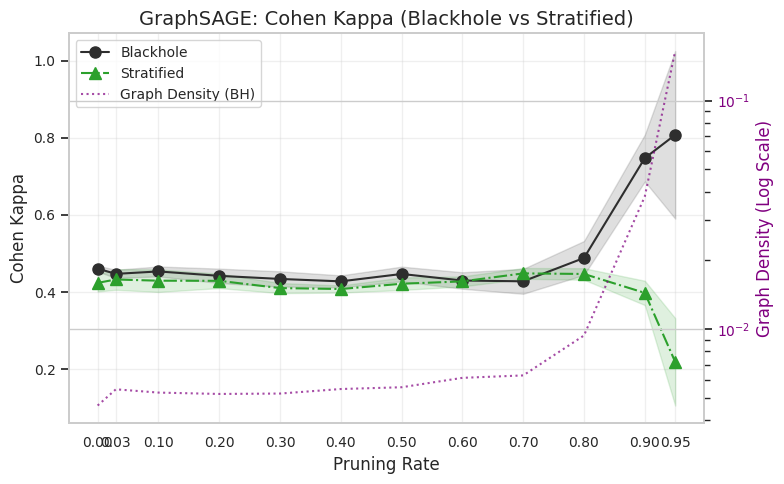

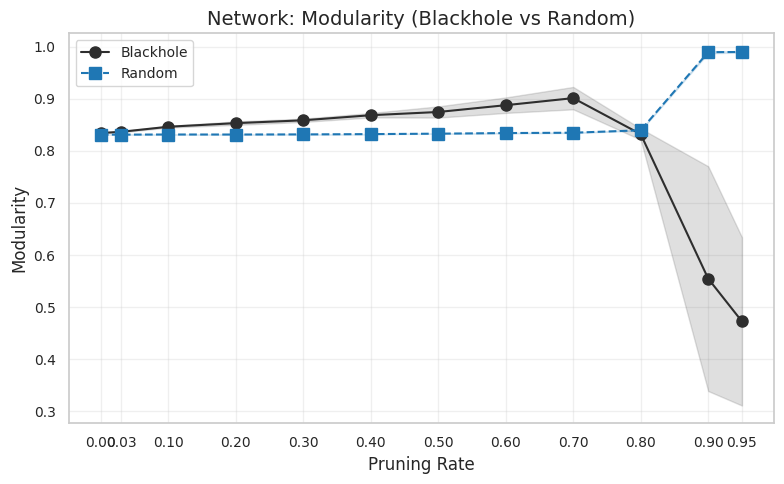

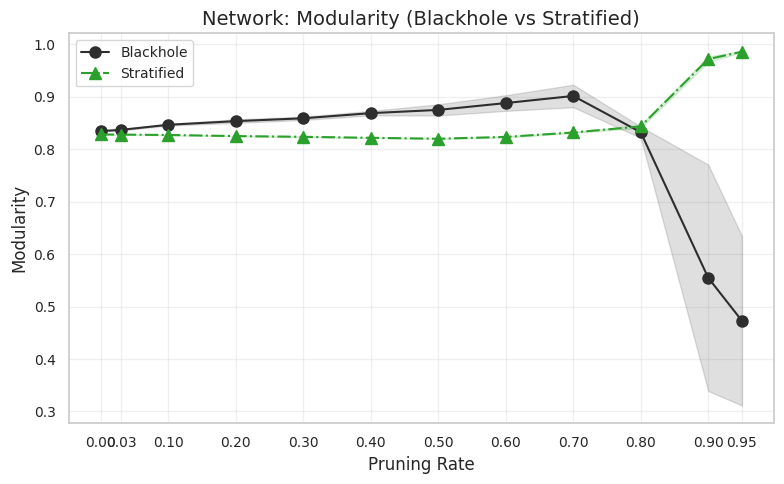

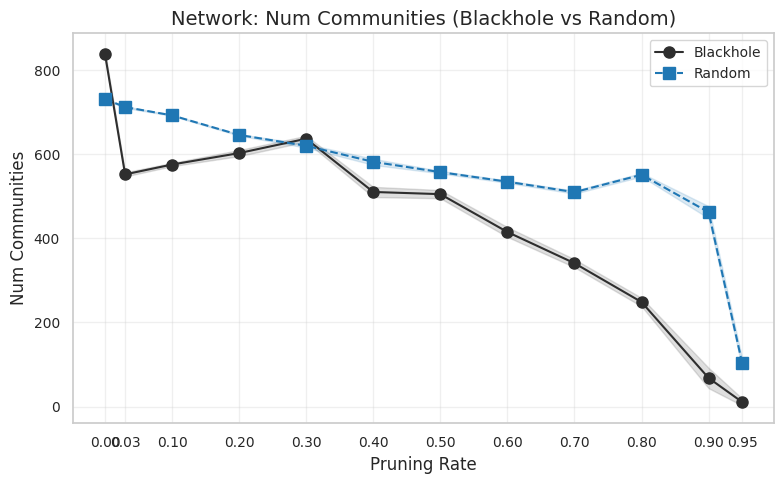

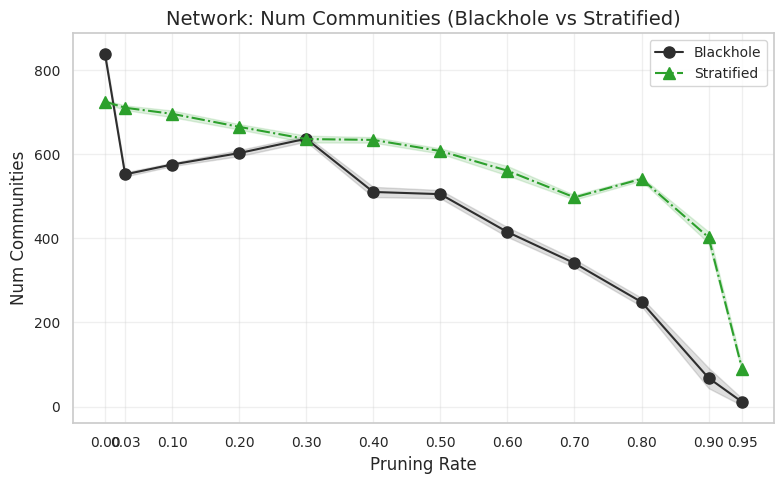

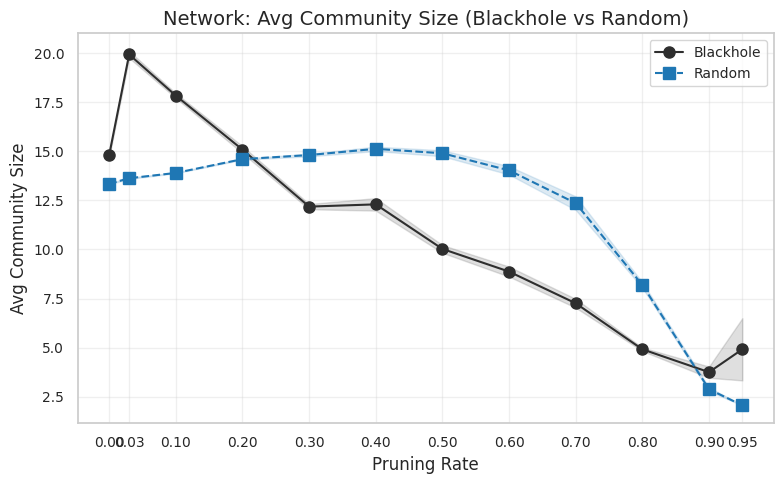

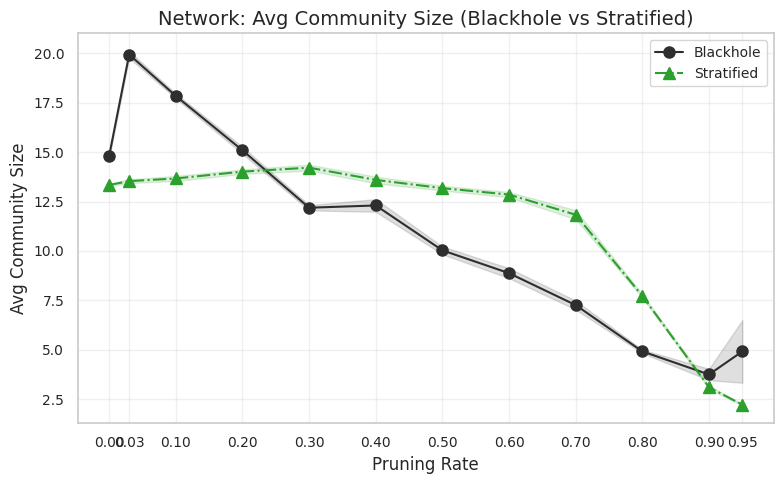

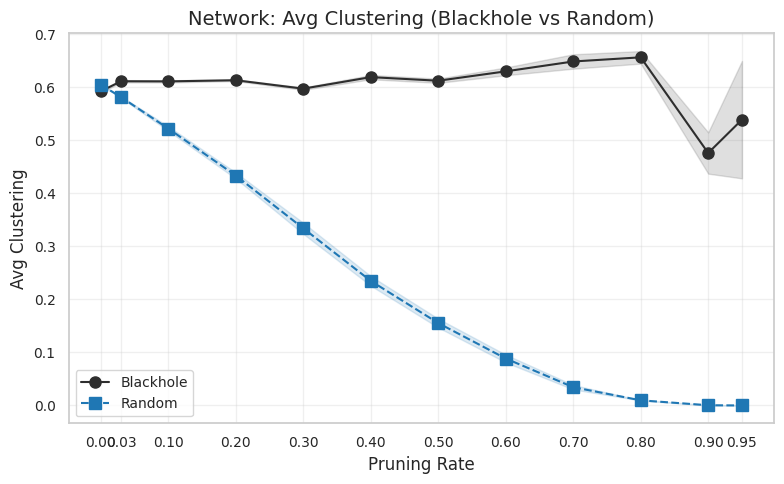

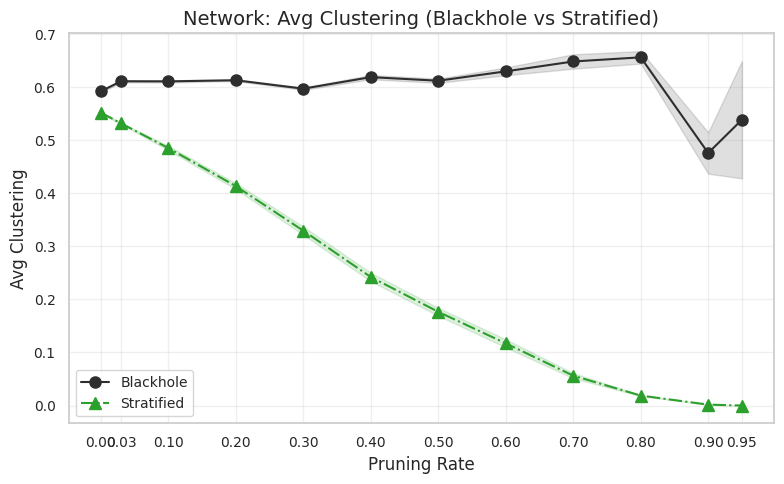

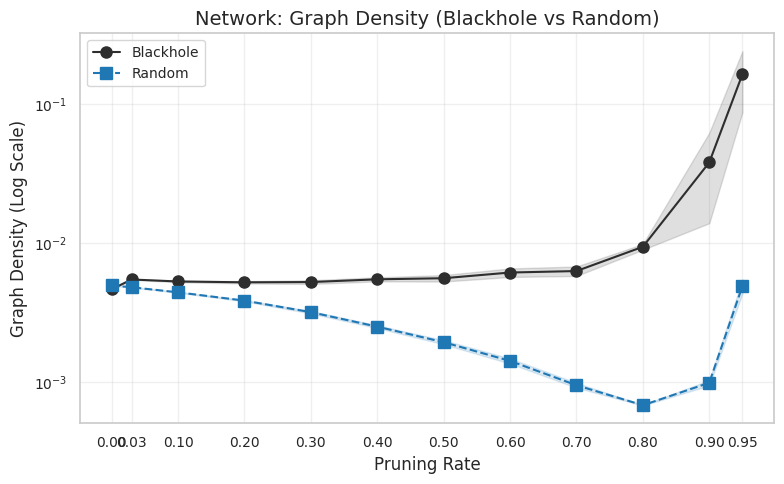

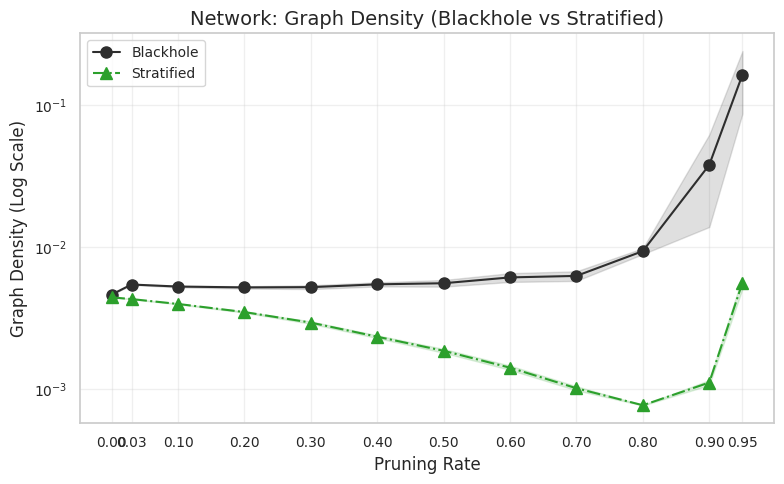

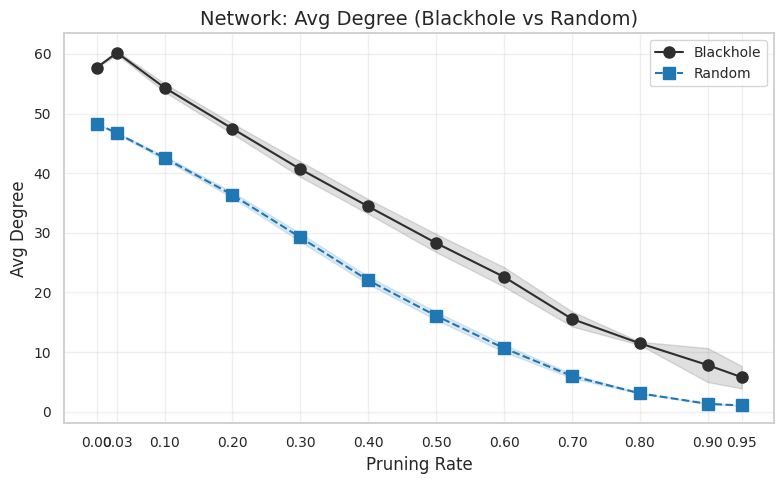

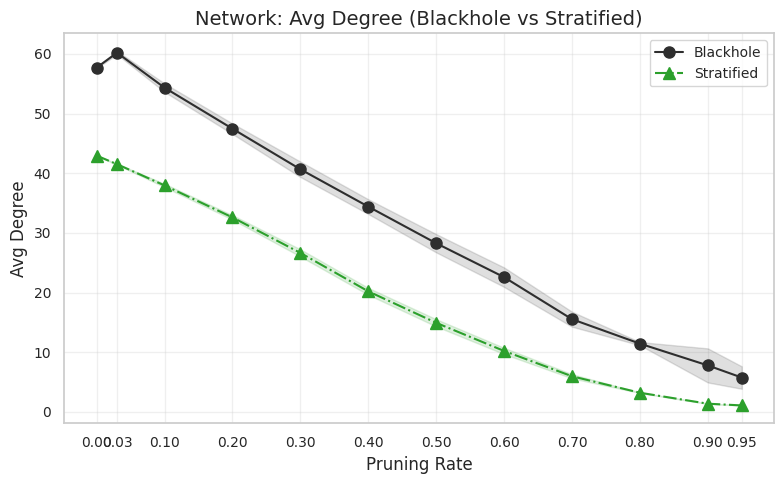

Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)
                     Accuracy_mean                     Accuracy_sem            \
Model                          GAT       GCN GraphSAGE          GAT       GCN   
Threshold Method                                                                
0.00      blackhole       0.632276  0.606623  0.621252     0.019801  0.005406   
          random          0.623554  0.636047  0.615361     0.033146  0.007119   
          stratified      0.628361  0.571482  0.590799     0.009908  0.040462   
0.03      blackhole       0.609334  0.590038  0.607137     0.022445  0.006509   
          random          0.610705  0.625630  0.606433     0.029775  0.006286   
          stratified      0.626805  0.587440  0.596962     0.020648  0.042499   
0.06      blackhole       0.617477  0.593562  0.606953     0.015280  0.011788   
          random          0.601141  0.628215  0.596032     0.029374  0.010291   
          stratified      0.627003  0.587355  0.593023

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid", context="notebook", palette="deep")

# Define consistent method colors, styles, and markers
method_colors = {
    'blackhole': '#2E2E2E',  # Dark gray for blackhole
    'random': '#1F77B4',     # Blue for random
    'stratified': '#2CA02C'  # Green for stratified
}
method_styles = {
    'blackhole': '-',
    'random': '--',
    'stratified': '-.'
}
method_markers = {
    'blackhole': 'o',
    'random': 's',
    'stratified': '^'
}

# Load data
#df = pd.read_csv('model_results_with_error_bars.csv')
df = pd.read_csv('https://raw.githubusercontent.com/MehrdadJalali-AI/BlackHole/main/evaluation_results/model_results_with_error_bars.csv')


# Calculate SEM (assuming num_runs=1 as per main.py)
df['Accuracy_sem'] = df['Accuracy_std'] / np.sqrt(1)
df['Cohen_Kappa_sem'] = df['Cohen_Kappa_std'] / np.sqrt(1)

# Metrics and corresponding stds
performance_metrics = [
    ('Accuracy_mean', 'Accuracy_sem'),
    ('Cohen_Kappa_mean', 'Cohen_Kappa_sem')
]
network_metrics = [
    ('Modularity_mean', 'Modularity_std'),
    ('Num_Communities_mean', 'Num_Communities_std'),
    ('Avg_Community_Size_mean', 'Avg_Community_Size_std'),
    ('Avg_Clustering_mean', 'Avg_Clustering_std'),
    ('Graph_Density_mean', 'Graph_Density_std'),
    ('Avg_Degree_mean', 'Avg_Degree_std')
]

# Models and thresholds (excluding 0.06 as per original request)
models = df['Model'].unique()
threshold_values = sorted(df[df['Threshold'] != 0.06]['Threshold'].unique())

# Font sizes
label_fontsize = 12
tick_fontsize = 10
title_fontsize = 14
legend_fontsize = 10

# Function to check for significant outperformance
def is_significant(bh_mean, bh_sem, other_mean, other_sem):
    return bh_mean - bh_sem > other_mean + other_sem

# Plotting function for pairwise comparisons
def plot_pairwise_comparison(subset, metric, std_metric, title_prefix, methods, comparison_name):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx() if metric in ['Accuracy_mean', 'Cohen_Kappa_mean'] else None

    # Plot data for each method
    for method in methods:
        method_data = subset[subset['Method'] == method].sort_values('Threshold')
        ax.plot(method_data['Threshold'], method_data[metric],
                label=f'{method.title()}',
                color=method_colors[method], linestyle=method_styles[method],
                marker=method_markers[method], markersize=8)
        ax.fill_between(method_data['Threshold'],
                        method_data[metric] - method_data[std_metric],
                        method_data[metric] + method_data[std_metric],
                        alpha=0.15, color=method_colors[method])

    # Add Graph Density on secondary y-axis for Accuracy and Cohen's Kappa
    if metric in ['Accuracy_mean', 'Cohen_Kappa_mean']:
        density_data = subset[subset['Method'] == 'blackhole'].sort_values('Threshold')
        ax2.plot(density_data['Threshold'], density_data['Graph_Density_mean'],
                 color='purple', linestyle=':', label='Graph Density (BH)', alpha=0.7)
        ax2.set_yscale('log')
        ax2.set_ylabel('Graph Density (Log Scale)', fontsize=label_fontsize, color='purple')
        ax2.tick_params(axis='y', labelsize=tick_fontsize, labelcolor='purple')

    # Annotations for significant outperformance (Accuracy only)
    if metric == 'Accuracy_mean':
        for thresh in threshold_values:
            bh_data = subset[(subset['Method'] == 'blackhole') & (subset['Threshold'] == thresh)]
            other_data = subset[(subset['Method'] == methods[1]) & (subset['Threshold'] == thresh)]
            if not (bh_data.empty or other_data.empty):
                bh_acc, bh_sem = bh_data['Accuracy_mean'].values[0], bh_data['Accuracy_sem'].values[0]
                other_acc, other_sem = other_data['Accuracy_mean'].values[0], other_data[std_metric].values[0]
                if is_significant(bh_acc, bh_sem, other_acc, other_sem):
                    ax.annotate('*', xy=(thresh, bh_acc), xytext=(0, 5),
                               textcoords='offset points', ha='center', color='red', fontsize=12)

    # Customize plot
    metric_name = metric.replace("_mean", "").replace("_", " ").title()
    ax.set_title(f'{title_prefix}: {metric_name} ({comparison_name})', fontsize=title_fontsize)
    ax.set_xlabel('Pruning Rate', fontsize=label_fontsize)
    ax.set_ylabel(metric_name, fontsize=label_fontsize)
    ax.set_xticks(threshold_values)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(True, alpha=0.3)

    # Adjust y-axis for Graph Density
    if metric == 'Graph_Density_mean':
        ax.set_yscale('log')
        ax.set_ylabel('Graph Density (Log Scale)', fontsize=label_fontsize)

    # Combine legends
    if ax2:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, fontsize=legend_fontsize, loc='upper left')
    else:
        ax.legend(fontsize=legend_fontsize, loc='best')

    plt.tight_layout()
    plt.show()

# Generate plots for performance metrics (model-dependent)
for model in models:
    subset = df[(df['Model'] == model) & (df['Threshold'] != 0.06)]
    for metric, std_metric in performance_metrics:
        # Blackhole vs Random
        plot_pairwise_comparison(
            subset[subset['Method'].isin(['blackhole', 'random'])],
            metric, std_metric, model, ['blackhole', 'random'], 'Blackhole vs Random'
        )
        # Blackhole vs Stratified
        plot_pairwise_comparison(
            subset[subset['Method'].isin(['blackhole', 'stratified'])],
            metric, std_metric, model, ['blackhole', 'stratified'], 'Blackhole vs Stratified'
        )

# Generate plots for network metrics (model-independent, using GAT data)
subset = df[(df['Model'] == 'GAT') & (df['Threshold'] != 0.06)]
for metric, std_metric in network_metrics:
    # Blackhole vs Random
    plot_pairwise_comparison(
        subset[subset['Method'].isin(['blackhole', 'random'])],
        metric, std_metric, 'Network', ['blackhole', 'random'], 'Blackhole vs Random'
    )
    # Blackhole vs Stratified
    plot_pairwise_comparison(
        subset[subset['Method'].isin(['blackhole', 'stratified'])],
        metric, std_metric, 'Network', ['blackhole', 'stratified'], 'Blackhole vs Stratified'
    )

# Calculate maximum and minimum distances of BH Accuracy from Random and Stratified
distances_bh_random = []
distances_bh_stratified = []

for thresh in threshold_values:
    for model in models:
        bh_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        rand_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'random') & (df['Model'] == model)]
        strat_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or rand_data.empty or strat_data.empty):
            bh_acc = bh_data['Accuracy_mean'].values[0]
            rand_acc = rand_data['Accuracy_mean'].values[0]
            strat_acc = strat_data['Accuracy_mean'].values[0]
            # Calculate distances
            dist_bh_random = bh_acc - rand_acc
            dist_bh_stratified = bh_acc - strat_acc
            distances_bh_random.append((dist_bh_random, thresh, model, bh_acc, rand_acc))
            distances_bh_stratified.append((dist_bh_stratified, thresh, model, bh_acc, strat_acc))

# Find maximum and minimum distances
max_dist_bh_random = max(distances_bh_random, key=lambda x: x[0])
min_dist_bh_random = min(distances_bh_random, key=lambda x: x[0])
max_dist_bh_stratified = max(distances_bh_stratified, key=lambda x: x[0])
min_dist_bh_stratified = min(distances_bh_stratified, key=lambda x: x[0])

# Summary Table for Performance Metrics
print("Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)")
summary_table = df.pivot_table(
    index=['Threshold', 'Method'],
    columns='Model',
    values=['Accuracy_mean', 'Accuracy_sem', 'Cohen_Kappa_mean', 'Cohen_Kappa_sem'],
    aggfunc='first'
)
print(summary_table)

# Summary Table for Network Metrics (using GAT data as representative)
print("\nSummary Table: Network Metrics (Mean ± Std)")
network_summary_table = df[df['Model'] == 'GAT'].pivot_table(
    index=['Threshold', 'Method'],
    values=[metric for metric, _ in network_metrics],
    aggfunc='first'
)
print(network_summary_table)

# Key Findings
print("\nKey Findings:")
# Significant outperformance
bh_outperform = []
for thresh in threshold_values:
    for model in models:
        bh_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        rand_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'random') & (df['Model'] == model)]
        strat_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or rand_data.empty or strat_data.empty):
            bh_acc, bh_sem = bh_data['Accuracy_mean'].values[0], bh_data['Accuracy_sem'].values[0]
            rand_acc, rand_sem = rand_data['Accuracy_mean'].values[0], rand_data['Accuracy_sem'].values[0]
            strat_acc, strat_sem = strat_data['Accuracy_mean'].values[0], strat_data['Accuracy_sem'].values[0]
            if is_significant(bh_acc, bh_sem, rand_acc, rand_sem) and \
               is_significant(bh_acc, bh_sem, strat_acc, strat_sem):
                bh_outperform.append((thresh, model, bh_acc, rand_acc, strat_acc))

if bh_outperform:
    print("Thresholds where Blackhole significantly outperforms both Random and Stratified (Accuracy):")
    for thresh, model, bh_acc, rand_acc, strat_acc in bh_outperform:
        print(f"- Threshold {thresh:.2f}, Model {model}: BH Accuracy = {bh_acc:.4f}, "
              f"Random = {rand_acc:.4f}, Stratified = {strat_acc:.4f}")
else:
    print("- No thresholds where Blackhole significantly outperforms both Random and Stratified.")

# Maximum and Minimum Distances
print("\nMaximum and Minimum Distances of Blackhole Accuracy from Random and Stratified:")
print("Blackhole vs Random:")
print(f"- Maximum Distance: {max_dist_bh_random[0]:.4f} at Threshold {max_dist_bh_random[1]:.2f}, Model {max_dist_bh_random[2]} "
      f"(BH Accuracy = {max_dist_bh_random[3]:.4f}, Random Accuracy = {max_dist_bh_random[4]:.4f})")
print(f"- Minimum Distance: {min_dist_bh_random[0]:.4f} at Threshold {min_dist_bh_random[1]:.2f}, Model {min_dist_bh_random[2]} "
      f"(BH Accuracy = {min_dist_bh_random[3]:.4f}, Random Accuracy = {min_dist_bh_random[4]:.4f})")
print("Blackhole vs Stratified:")
print(f"- Maximum Distance: {max_dist_bh_stratified[0]:.4f} at Threshold {max_dist_bh_stratified[1]:.2f}, Model {max_dist_bh_stratified[2]} "
      f"(BH Accuracy = {max_dist_bh_stratified[3]:.4f}, Stratified Accuracy = {max_dist_bh_stratified[4]:.4f})")
print(f"- Minimum Distance: {min_dist_bh_stratified[0]:.4f} at Threshold {min_dist_bh_stratified[1]:.2f}, Model {min_dist_bh_stratified[2]} "
      f"(BH Accuracy = {min_dist_bh_stratified[3]:.4f}, Stratified Accuracy = {min_dist_bh_stratified[4]:.4f})")

# Highlight highest accuracy
max_acc_row = df.loc[df['Accuracy_mean'].idxmax()]
print(f"\nHighest Accuracy: {max_acc_row['Accuracy_mean']:.4f} by {max_acc_row['Model']} "
      f"({max_acc_row['Method']}) at Threshold {max_acc_row['Threshold']:.2f}, "
      f"with Graph Density = {max_acc_row['Graph_Density_mean']:.6f}")